<a name="top" id="top"></a>

<div align="center">
    <h1>Sensor Placement and Fault Diagnosis in Real Water Distribution Netwroks</h1>
    <a href="https://github.com/anurag-r20">Anurag Ramesh</a>
    <br>
    <i>Graduate Research Assistant</i>
    <br>
    <i>Davidson School of Chemical Engineering, Purdue University</i>
    <br>
    <br>
    <a href="https://github.com/bernalde">David E. Bernal Neira</a>
    <br>
    <i> Assistant Professor </i>
    <br>
    <i>Davidson School of Chemical Engineering, Purdue University</i>
    <br>
    <br>
   <a href="https://colab.research.google.com/github.com/anurag-r20/WDN_Sensor_Placement/WDN_Sensor_Placement.ipynb">
    <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
    </a>
    <a href="https://secquoia.github.io/">
        <img src="https://img.shields.io/badge/🌲⚛️🌐-SECQUOIA-blue" alt="SECQUOIA"/>
    </a>
</div>

## Sensor Placement in Water Distribution Networks (WDN)

In this notebook, we formulate an optimization problem to identify the optimal placement of pressure sensors in a Water Distribution Network (WDN). The WDN is represented on a constrained graph $G(V,E)$, where $V$ is the set of vertices and $E$ is the set of edges.

We consider two different formulations of the optimization problem, including Mixed Integer Programming (MIP), Mixed Integer Quadratic Programming (MIQP), and Quadratic Unconstrained Binary Optimization (QUBO). The optimization problem is solved using three different solvers: Gurobi, Simulated Annealing, and D-Wave's implementation of Quantum Annealing via **[neal](https://github.com/dwavesystems/dwave-neal)**.

Additionally, we leverage D-Wave's package **[dwavebinarycsp](https://github.com/dwavesystems/dwavebinarycsp)** to translate constraint satisfaction problems into QUBOs. For Groebner basis computations, we use **[Sympy](https://www.sympy.org/)** for symbolic computation in Python and **[Networkx](https://networkx.github.io/)** for network models and graphs.

In [1]:
# If using this on Google collab, we need to install the packages
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

# Let's install dimod, neal, and pyomo
if IN_COLAB:
    !pip install -q pyomo
    !pip install dimod
    !pip install dwave-neal

if IN_COLAB:
    !pip install dwave-ocean-sdk

In [2]:
# Import the Pyomo library, which can be installed via pip, conda or from Github https://github.com/Pyomo/pyomo
import pyomo.environ as pyo
# Import the Dwave packages dimod and neal
import dimod
import neal
from tabu import TabuSampler
# Import Matplotlib to generate plots
import matplotlib.pyplot as plt
# Import numpy and scipy for certain numerical calculations below
import numpy as np
from scipy.special import gamma
import pandas as pd
pd.options.display.float_format = '{:.6f}'.format
import os
import time
import operator
from collections import OrderedDict
from collections import Counter
# Import networkx for graph problems
import networkx as nx
from matplotlib.lines import Line2D


In [3]:
def WDN_network_data(city, base_dir=None):

    """Fetches and processes Water Distribution Network (WDN) data for a given city.

    This function reads node, edge, and water consumption data from specified files
    for a given city and returns the data as dictionaries.

    Args:
        city (str): The name of the city to fetch data for. Should be one of 'Apulia', 
            'Fossolo', or 'Test'.
        base_dir (str, optional): The base directory where the data files are located. 
            Defaults to the directory of the script.

    Returns:
        tuple: A tuple containing three dictionaries:
            - nodes (dict): Dictionary of nodes with node names as keys and (x, y) 
              coordinates as values.
            - edges (dict): Dictionary of edges with tuples of node pairs as keys.
            - water_consumption (dict): Dictionary of water consumption with node names
              as keys and consumption values as values.

    Raises:
        FileNotFoundError: If any of the data files do not exist.
        ValueError: If the provided city name is not valid.

    Examples:
        >>> nodes, edges, water_consumption = WDN_network_data('Apulian')
        >>> print(nodes)
        {'J1': (10.0, 20.0), 'J2': (15.0, 25.0)}
    """

    # Set base directory
    if base_dir is None:
        base_dir = os.path.dirname(os.path.abspath(__file__))  # Set to script's directory
    
    data_dir = os.path.join(base_dir, 'Data/WDN_Data')
    city_files = {
        "Apulia": {
            "nodes": f"{data_dir}/Apulia_WDN/Apulia_WDN_Nodes.txt",
            "edges": f"{data_dir}/Apulia_WDN/Apulia_WDN_Edges.txt",
            "water_consumption": f"{data_dir}/Apulia_WDN/Apulia_WDN_Water_Consumption.txt"
        },
        "Fossolo": {
            "nodes": f"{data_dir}/Fossolo_WDN/Fossolo_WDN_Nodes.txt",
            "edges": f"{data_dir}/Fossolo_WDN/Fossolo_WDN_Edges.txt",
            "water_consumption": f"{data_dir}/Fossolo_WDN/Fossolo_WDN_Water_Consumption.txt"
        },
        "Test": {
            "nodes": f"{data_dir}/Test_WDN/Test_Nodes.txt",
            "edges": f"{data_dir}/Test_WDN/Test_Edges.txt",
            "water_consumption": f"{data_dir}/Test_WDN/Test_Water_Consumption.txt"
        },
        "ZJ": {
            "nodes": f"{data_dir}/ZJ_WDN/ZJ_WDN_Nodes.txt",
            "edges": f"{data_dir}/ZJ_WDN/ZJ_WDN_Edges.txt",
            "water_consumption": f"{data_dir}/ZJ_WDN/ZJ_WDN_Water_Consumption.txt"
        },
        "Modena": {
            "nodes": f"{data_dir}/Modena_WDN/Modena_WDN_Nodes.txt",
            "edges": f"{data_dir}/Modena_WDN/Modena_WDN_Edges.txt",
            "water_consumption": f"{data_dir}/Modena_WDN/Modena_WDN_Water_Consumption.txt"
        },
        "Kentucky": {
            "nodes": f"{data_dir}/Kentucky_WDN/Kentucky_WDN_Nodes.txt",
            "edges": f"{data_dir}/Kentucky_WDN/Kentucky_WDN_Edges.txt",
            "water_consumption": f"{data_dir}/Kentucky_WDN/Kentucky_WDN_Water_Consumption.txt"
        }
        #  "Test": {
        #     "nodes": f"{data_dir}/Test_WDN/Test_Nodes_5.txt",
        #     "edges": f"{data_dir}/Test_WDN/Test_Edges_5.txt",
        #     "water_consumption": f"{data_dir}/Test_WDN/Test_Water_Consumption_5.txt"
        # }      
    }

    # Check if the city is valid
    if city not in city_files:
        print(f"Error: Unknown city {city}.")
        return None, None, None

    # Get file paths
    nodes_file_path = city_files[city]["nodes"]
    edges_file_path = city_files[city]["edges"]
    water_consumption_file_path = city_files[city]["water_consumption"]

    # Print absolute file paths for debugging
    print(f"Nodes file path: {nodes_file_path}")
    print(f"Edges file path: {edges_file_path}")
    print(f"Water consumption file path: {water_consumption_file_path}")

    # Check if files exist
    for file_path in [nodes_file_path, edges_file_path, water_consumption_file_path]:
        if not os.path.exists(file_path):
            print(f"Error: The file {file_path} does not exist.")
            return None, None, None

    # Importing node data
    nodes_df = pd.read_csv(nodes_file_path, skiprows=1, names=["Node", "X", "Y"]) # nodes dataframe (exclude heading)
    nodes_df['Node'] = nodes_df['Node'].str.strip() # strip spaces
    nodes = {row['Node']: (float(row['X']), float(row['Y'])) for i, row in nodes_df.iterrows()} # Convert the data to a dictionary with node names as keys and (x, y) tuples as values.

    # Importing edge data
    edges_df = pd.read_csv(edges_file_path, skiprows=1, names=["Node1", "Node2"]) # edges dataframe
    edges_df['Node1'] = edges_df['Node1'].str.strip() # strip spaces
    edges_df['Node2'] = edges_df['Node2'].str.strip()
    edges = {((row['Node1']), (row['Node2'])) for i, row in edges_df.iterrows()} # Convert the data to a dictionary with node names as keys and (x, y) tuples as values.
    
    # Importing water consumption data
    water_consumption_df = pd.read_csv(water_consumption_file_path, skiprows=1, names=["Node", "Consumption"]) # water consumption dataframe
    water_consumption_df['Node'] = water_consumption_df['Node'].str.strip() # strip spaces
    water_consumption = {row['Node']: (float(row['Consumption'])) for i, row in water_consumption_df.iterrows()} # Convert the data to a dictionary with node names as keys and (x, y) tuples as values.

    return nodes, edges, water_consumption

In [4]:
base_dir = '/mnt/c/Users/rames102/Desktop/Qualifier_2024'  # relpace with correct directory in your system
city = "ZJ"
coords, edges, water_consumption = WDN_network_data(city, base_dir)

Nodes file path: /mnt/c/Users/rames102/Desktop/Qualifier_2024/Data/WDN_Data/ZJ_WDN/ZJ_WDN_Nodes.txt
Edges file path: /mnt/c/Users/rames102/Desktop/Qualifier_2024/Data/WDN_Data/ZJ_WDN/ZJ_WDN_Edges.txt
Water consumption file path: /mnt/c/Users/rames102/Desktop/Qualifier_2024/Data/WDN_Data/ZJ_WDN/ZJ_WDN_Water_Consumption.txt


In [5]:
def Construct_Graph(city):

    """Constructs a Water Distribution Network (WDN) graph for a given city.

    This function constructs a graph using the node coordinates and edges imported previously.
    It creates a NetworkX graph, adds nodes with their coordinates as attributes, and adds edges.

    Args:
        city (str): The name of the city for which to construct the graph. The function assumes
            that the node coordinates and edges for the specified city have been imported.

    Returns:
        nx.Graph: A NetworkX graph object representing the WDN. If the coordinates or edges are
            not available, returns None.

    Raises:
        ValueError: If the city name is not valid or if the necessary data is missing.

    Examples:
        >>> G = Construct_Graph('Apulian')
        >>> print(G.nodes(data=True))
        [('J1', {'pos': (10.0, 20.0)}), ('J2', {'pos': (15.0, 25.0)})]
    """

    if coords is None or edges is None:
        return None
    
    G = nx.Graph()

    # Defining Nodes in their coordinates
    for node, coord in coords.items():
        G.add_node(node, pos=coord)

    # Add edges
    G.add_edges_from(edges)
    
    return G

In [6]:
G = Construct_Graph(city)
print(G)

Graph with 114 nodes and 162 edges


In [7]:
def centrality(G, water_consumption):

    """Calculates centrality metrics for a given city's WDN graph and water consumption data.

    This function computes various centrality metrics for the provided NetworkX graph and calculates
    vertex costs based on water consumption data and centrality measures.

    Args:
        G (nx.Graph): A NetworkX graph representing the water distribution network (WDN) for the city.
        water_consumption (dict): A dictionary where keys are node names and values are the water consumption
            at each node.

    Returns:
        tuple: A tuple containing two elements:
            - vertex_cost (dict): Dictionary where keys are node names and values are the computed costs
              for each vertex based on normalized demand and degree centrality.
            - edge_betweenness (dict): Dictionary of edge betweenness centrality values, where keys are
              tuples representing edges and values are the betweenness centrality scores for those edges.

    Raises:
        KeyError: If a node from the graph is not found in the water consumption data.

    Examples:
        >>> vertex_cost, edge_betweenness = centrality(G, water_consumption)
        >>> print(vertex_cost)
        {'J1': 2.5, 'J2': 3.0}
        >>> print(edge_betweenness)
        {(J1, J2): 0.1, (J2, J3): 0.2}
    """
    
    # Calculating edge betweenness centrality
    edge_betweenness = nx.edge_betweenness_centrality(G)

    # Calculate degree centrality
    degree_centrality = nx.degree_centrality(G)

    # Edge betweenness centrality as weights
    for (u, v, d) in G.edges(data=True):
        d['weight'] = edge_betweenness[(u, v)]

    # Define the weights C and D (Need to identify the right values)
    C = 1.0
    D = 1.0

    def compute_normalized_demand(water_consumption):        
        max_demand = max(water_consumption.items(), key=operator.itemgetter(1))[1]
        return {node: val / max_demand for node, val in water_consumption.items()}

    normalized_demand = compute_normalized_demand(water_consumption)

    # Debugging: print the node names in the graph
    print("Graph nodes:", list(G.nodes()))
    
    # Debugging: print the keys in normalized_demand
    print("Normalized demand keys:", list(normalized_demand.keys()))

    # Vertex cost function:
    vertex_cost = {}
    for node in G.nodes():
        f_i = normalized_demand.get(node, None)   # function of the water need at each node i
        if f_i is None:
            print(f"Node {node} not found in normalized_demand")
            continue
        g_i = degree_centrality[node] / (len(G.nodes()) - 1)    # node weights
        vertex_cost[node] = C * f_i + D * g_i
    
    return vertex_cost, edge_betweenness


In [8]:
VC, EB = centrality(G, water_consumption)
print(VC)
print(EB)

Graph nodes: ['J-1', 'J-2', 'J-3', 'J-4', 'J-5', 'J-6', 'J-7', 'J-8', 'J-9', 'J-10', 'J-11', 'J-12', 'J-13', 'J-14', 'J-15', 'J-16', 'J-17', 'J-18', 'J-19', 'J-20', 'J-21', 'J-22', 'J-23', 'J-24', 'J-25', 'J-26', 'J-27', 'J-28', 'J-29', 'J-30', 'J-31', 'J-32', 'J-33', 'J-34', 'J-35', 'J-36', 'J-37', 'J-38', 'J-39', 'J-40', 'J-41', 'J-42', 'J-43', 'J-44', 'J-45', 'J-46', 'J-47', 'J-48', 'J-49', 'J-50', 'J-51', 'J-52', 'J-53', 'J-54', 'J-55', 'J-56', 'J-57', 'J-58', 'J-59', 'J-60', 'J-61', 'J-62', 'J-63', 'J-64', 'J-65', 'J-66', 'J-67', 'J-68', 'J-69', 'J-70', 'J-71', 'J-72', 'J-73', 'J-74', 'J-75', 'J-76', 'J-77', 'J-78', 'J-79', 'J-80', 'J-81', 'J-82', 'J-83', 'J-84', 'J-85', 'J-86', 'J-87', 'J-88', 'J-89', 'J-90', 'J-91', 'J-92', 'J-93', 'J-94', 'J-95', 'J-96', 'J-97', 'J-98', 'J-99', 'J-100', 'J-101', 'J-102', 'J-103', 'J-104', 'J-105', 'J-106', 'J-107', 'J-108', 'J-109', 'J-110', 'J-111', 'J-112', 'J-113', 'T-114']
Normalized demand keys: ['J-1', 'J-2', 'J-3', 'J-4', 'J-5', 'J-6', '

In [9]:
def plot_WDN(G):

    """Plots the graph of the city's Water Distribution Network (WDN).

    This function visualizes the WDN graph using NetworkX and Matplotlib. It plots nodes with their
    positions, edges, and labels for both nodes and edges. It also includes a legend and title for the plot.

    Args:
        G (nx.Graph): A NetworkX graph object representing the water distribution network (WDN) for the city.

    Returns:
        None

    Raises:
        ValueError: If the graph `G` is None or the position dictionary is empty.

    Examples:
        >>> plot_WDN(G)
    """

    if G is None:
        print(f"Graph could not be constructed for {city}.")
        return

    pos = nx.get_node_attributes(G, 'pos')
    
    if not pos:
        print("Error: Position dictionary is empty.")
        return

    print("Position Dictionary:", pos)

    # Create plot
    plt.figure(figsize=(24, 16))
    nx.draw_networkx_nodes(G, pos, node_size=500, node_color='skyblue')
    nx.draw_networkx_edges(G, pos, edge_color='black')

    # Round off edge and node labels to two decimals for the plot
    edge_labels_rounded = {k: round(v, 2) for k, v in EB.items()}
    node_labels_rounded = {k: round(v, 2) for k, v in VC.items()}

    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels_rounded, label_pos=0.5, font_size=6, verticalalignment='bottom')
    nx.draw_networkx_labels(G, pos, labels=node_labels_rounded, font_size=8, font_color='black')

    # Add legend
    blue_patch = Line2D([0], [0], marker='o', color='w', markerfacecolor='skyblue', markersize=10, label='Potential nodes for sensor placement')
    plt.legend(handles=[blue_patch], loc='best', fontsize='24')

    # plt.title(f"Water Distribution Network - {city}", fontsize = 80)
    plt.show()

Position Dictionary: {'J-1': (514.65, 282.74), 'J-2': (512.5, 323.72), 'J-3': (474.74, 321.84), 'J-4': (476.62, 290.78), 'J-5': (482.78, 269.84), 'J-6': (491.78, 215.4), 'J-7': (519.37, 215.85), 'J-8': (491.34, 184.97), 'J-9': (491.16, 153.31), 'J-10': (519.59, 152.31), 'J-11': (467.79, 112.47), 'J-12': (503.42, 89.26), 'J-13': (158.61, 336.94), 'J-14': (445.56, 82.49), 'J-15': (469.94, 61.74), 'J-16': (496.3, -18.85), 'J-17': (480.23, 6.24), 'J-18': (447.89, 42.8), 'J-19': (427.3, 66.41), 'J-20': (402.44, 95.45), 'J-21': (430.51, 134.96), 'J-22': (432.32, 160.66), 'J-23': (435.02, 189.51), 'J-24': (436.56, 217.31), 'J-25': (437.61, 261.36), 'J-26': (437.1, 291.23), 'J-27': (436.47, 321.13), 'J-28': (431.62, 374.68), 'J-29': (368.0, 394.46), 'J-30': (363.49, 364.6), 'J-31': (363.46, 319.23), 'J-32': (403.56, 320.45), 'J-33': (402.56, 291.22), 'J-34': (435.63, 342.95), 'J-35': (401.37, 261.2), 'J-36': (400.58, 230.38), 'J-37': (398.49, 194.73), 'J-38': (391.68, 160.36), 'J-39': (369.54,

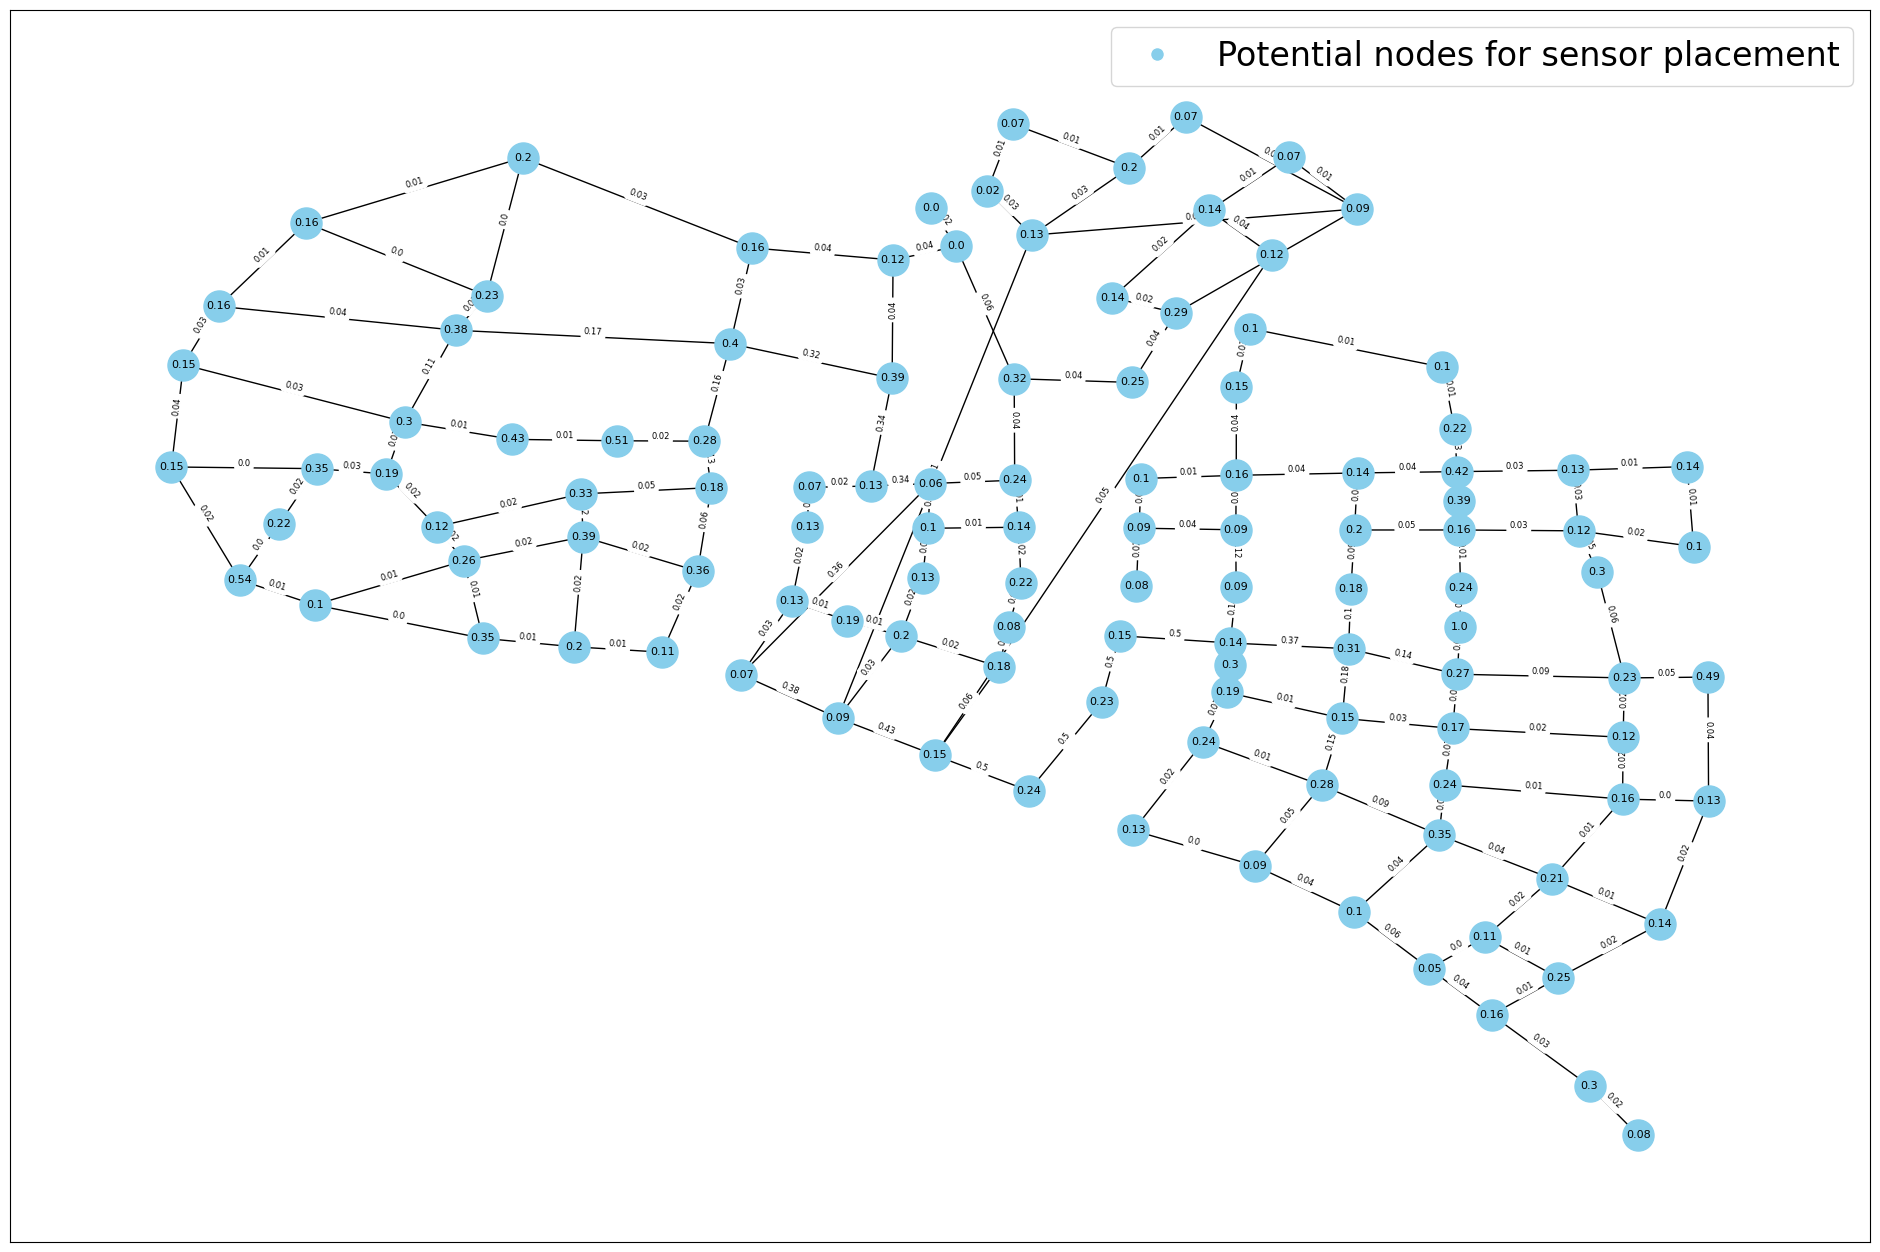

In [10]:
plot_WDN(G)

The solution to this graph problem is explored using different reformulations of the problem.

First, we formulate the graph optimization problem as a Mixed Integer Program (MIP) (Speziali et al. (2021)):


$$
\begin{array}{rl}
    \displaystyle%
    \min_{x} & \sum_{i \in V} c_{i}x_{i} + \sum_{(i, j) \in E} w_{ij}(1 - x_{j} - x_{i} + x_{i}x_{j}) \\
    \textrm{s.t.} & \sum_{i \in V} x_{i} = s \\
    & x_{i} \in \{0,1 \}^{n}
\end{array}
$$

Here, $c_{i}$ represents the cost of the $i^{th}$ node, $w_{ij}$ represents the weight corresponding to the edge between nodes $i$ and $j$, and $x_{i} \in \{0, 1\}^{n}$ is a binary decision variable that indicates whether a sensor is placed at the $i^{th}$ node. $s$ is the predefined total number of sensors.

Next, the Quadratic Unconstrained Binary Optimzation (QUBO) formulation of the graph problem is explored. Consider the MIP model from before:
$$
\begin{array}{rl}
    \displaystyle%
    \min_{x} & \sum_{i \in V} c_{i}x_{i} + \sum_{(i, j) \in E} w_{ij}(1 - x_{j} - x_{i} + x_{i}x_{j}) \\
    \textrm{s.t.} & \sum_{i \in V} x_{i} = s \\
    & x_{i} \in \{0,1 \}^{n}
\end{array}
$$
To implement the problem as a QUBO, the constraint should be lifted up into the objective function such that the problem becomes unconstrained. This is performed as follows:
$$
\begin{array}{rl}
    \displaystyle%
    \min_{x} & \sum_{i \in V} c_{i}x_{i} + \sum_{(i, j) \in E} (w_{ij}(1 - x_{j} - x_{i} + x_{i}x_{j})) + \rho(\sum_{i \in V} x_{i} - s)^2 \\
\end{array}
$$
where $\rho$ is a scalar penalty term. Further simplification leads to
$$
\begin{array}{rl}
    \displaystyle%
    \min_{x} & \sum_{i \in V} c_{i}x_{i} + \sum_{(i, j) \in E} w_{ij} - \sum_{(i, j) \in E} w_{ij}x_{j} - \sum_{(i, j) \in E} w_{ij}x_{i} + \sum_{(i, j) \in E} w_{ij}x_{i}x_{j} + \rho\sum_{i \in V} x_{i}^2 - 2\rho\sum_{i \in V} x_{i}s + \rho s^2 \\
\end{array}
$$
Since, $x_{i}$ is a binary variable, we can write $x_{i}$ as $x_{i}^2$. Taking this into account, the problem now becomes: 
$$
\begin{array}{rl}
    \displaystyle%
    \min_{x} & \sum_{i \in V} c_{i}x_{i}^2 + \sum_{(i, j) \in E}w_{ij} - \sum_{(i, j) \in E} w_{ij}x_{j}^2 - \sum_{(i, j) \in E} w_{ij}x_{i}^2 + \sum_{(i, j) \in E} w_{ij}x_{i}x_{j} + \rho\sum_{i \in V} x_{i}^2 - 2\rho\sum_{i \in V} x_{i}^2s + \rho s^2 \\
\end{array}
$$
Performing some algebraic manipulations, we have our QUBO problem.
$$
\begin{array}{rl}
    \displaystyle%
    \min_{x} \left( \sum_{i \in V} (c_i + \rho - 2\rho s - w_{ij})x_i^2 + \sum_{(i,j) \in E} w_{ij}x_i x_j + \rho s^2 + \sum_{(i,j) \in E}{w_{ij}} \right) \\
\end{array}
$$
where $s$ is the total number of sensors that is predefined.

In [11]:
def create_pyomo_model(G): 

    """Initializes a Pyomo model for optimizing sensor placement in a city's Water Distribution Network (WDN).

    This function sets up a Pyomo model with nodes, edges, and associated parameters such as demand,
    vertex cost, and edge betweenness. It also defines the binary decision variables for sensor placement.

    Args:
        G (nx.Graph): A NetworkX graph object representing the water distribution network (WDN) for the city.

    Returns:
        pyo.ConcreteModel: A Pyomo ConcreteModel instance with sets, parameters, and decision variables defined.

    Raises:
        ValueError: If the graph `G` is None.

    Examples:
        >>> model = create_pyomo_model(G)
        >>> print(model)
    """

    if G is None:
        print(f"{city} does not exist.")
        return None

    # Create a pyomo model
    model = pyo.ConcreteModel()

    # Define pyomo sets for graph G
    nodes = list(G.nodes())
    edges = list(G.edges())
    model.nodes = pyo.Set(initialize=nodes)
    model.edges = pyo.Set(initialize=edges, dimen=2)

    # Parameters
    demand = water_consumption
    model.demand = pyo.Param(model.nodes, initialize=demand, mutable=True)
    model.c = pyo.Param(model.nodes, initialize=VC, mutable=True)  # vertex cost
    model.w = pyo.Param(model.edges, initialize=EB, mutable=True)  # edge_betweenness for edge weights

    # Binary decision variable
    model.x = pyo.Var(model.nodes, within=pyo.Binary)

    return model

In [12]:
model = create_pyomo_model(G)

In [13]:
# Mixed Integer Program model (MIP)
    
def MIQP(G, model_in, s):

    """Generates a Mixed Integer Programming (MIP) model for the given sensor placement problem.

    This function defines the objective function and constraints for the MIP model, aiming to optimize
    sensor placement in the city's Water Distribution Network (WDN). The objective function minimizes
    the total cost based on vertex costs and edge betweenness, while the constraint ensures that exactly
    `s` sensors are placed.

    Args:
        G (nx.Graph): A NetworkX graph object representing the water distribution network (WDN) for the city.
        model (pyo.ConcreteModel): A Pyomo ConcreteModel instance with sets and parameters defined.
        s (int): The number of sensors to be placed in the network.

    Returns:
        pyo.ConcreteModel: The updated Pyomo model with the objective function and constraints added.

    Raises:
        ValueError: If the model is None.

    Examples:
        >>> model = MIQP(G, model, 5)
        >>> print(model.obj)
    """

    if model_in is None:
        return None

    model = model_in.clone()
    
    # Define objective function
    def objective_rule_MIQP(model):
        return sum(model.c[i] * model.x[i] for i in model.nodes) + \
                sum(model.w[(i, j)] * (1 - model.x[i] - model.x[j] + model.x[i] * model.x[j]) for (i, j) in model.edges)

    model.obj = pyo.Objective(rule=objective_rule_MIQP, sense=pyo.minimize)

    # Constraints
    def sensor_constraint_rule_MIQP(model):
        return sum(model.x[i] for i in model.nodes) <= s

    model.sensor_constraint_MIQP = pyo.Constraint(rule=sensor_constraint_rule_MIQP)

    return model

In [14]:
# Quadratic Unconstrained Binary Optimization model (QUBO)

def QUBO(G, model_in, s, rho):

    """Generates a Quadratic Unconstrained Binary Optimization (QUBO) model for the given problem.

    This function defines the objective function for the QUBO model, which aims to optimize sensor placement
    in the city's Water Distribution Network (WDN). The objective function includes terms for vertex costs,
    edge interactions, and a penalty for deviating from the specified number of sensors.

    Args:
        G (nx.Graph): A NetworkX graph object representing the water distribution network (WDN) for the city.
        model (pyo.ConcreteModel): A Pyomo ConcreteModel instance with sets and parameters defined.
        s (int): The number of sensors to be placed in the network.
        rho (float): Penalty parameter for the constraint that exactly `s` sensors must be placed.

    Returns:
        pyo.ConcreteModel: The updated Pyomo model with the QUBO objective function added.

    Raises:
        ValueError: If the model is None.

    Examples:
        >>> model = QUBO(G, model, 5, 0.1)
        >>> print(model.obj)
    """

    if model_in is None:
        return None

    model = model_in.clone()

    # # Removing previous objective function definition:
    # if hasattr(model, 'obj'):
    #     model.del_component(model.obj)
    # model.obj = pyo.Objective(rule=objective_rule_MIQP, sense=pyo.minimize)

    # # Removing previous constraint definition:
    # if hasattr(model, 'sensor_constraint'):
    #     model.del_component(model.sensor_constraint_MIQP)
    # model.sensor_constraint_MIQP = pyo.Constraint(rule=sensor_constraint_rule_MIQP)


    # Define objective function 
    def objective_rule_QUBO(model):
        term1 = sum(model.c[i] * model.x[i] for i in model.nodes)
        term2 = sum(model.w[(i, j)] * (1 - model.x[i]) * (1 - model.x[j]) for (i, j) in model.edges)
        term3 = rho * (sum(model.x[i] for i in model.nodes) - s) ** 2
        return term1 + term2 + term3

    model.obj = pyo.Objective(rule=objective_rule_QUBO, sense=pyo.minimize)

    return model

    # No constraints for QUBO

In [15]:
# Coverage plot

solver = pyo.SolverFactory('gurobi', solver_io='python')
objective_value_list_MIP = []

def coverage(G, s, rho):
    """Computes and plots coverage metrics for the Water Distribution Network (WDN) using both MIP and QUBO formulations.

    This function iteratively solves the MIP and QUBO models for different numbers of sensors and records
    the objective values. It uses the Gurobi solver to find the optimal solutions and appends the results
    to lists for comparison.

    Args:
        G (nx.Graph): A NetworkX graph object representing the water distribution network (WDN) for the city.
        s (int): The maximum number of sensors to be placed.
        rho (float): Penalty parameter for the QUBO model.

    Returns:
        tuple: A tuple containing two lists:
            - objective_value_list_MIQP (list): A list of objective values obtained from the MIP formulation.
            - objective_value_list_QUBO (list): A list of objective values obtained from the QUBO formulation.

    Raises:
        ValueError: If the solver or model is not properly defined.

    Examples:
        >>> objective_value_list_MIQP, objective_value_list_QUBO = coverage(G, 5, 0.1)
        >>> print(objective_value_list_MIQP)
        [100, 95, 90]
        >>> print(objective_value_list_QUBO)
        [102, 96, 89]
    """

    # MIP
    for s in range(0, len(G.nodes())+1):
        model_MIQP = MIQP(G, model, s)
        # Solve MIP and append data to list for each iteration
        results_MIQP = solver.solve(model_MIQP, tee=True) # MIP formulation result
        objective_value_MIP = pyo.value(model_MIQP.obj)
        print("Objective value from MIP formulation: \n", objective_value_MIP)
        print("\n")
        objective_value_list_MIP.append(objective_value_MIP)

    return objective_value_list_MIP

In [16]:
def plot_coverage(s, objective_value_list_MIP):
    """
    Plots the objective value against the number of sensors and marks the minimum objective value.

    Args:
        s (int): The maximum number of sensors to be placed.
        objective_value_list_MIP (list): A list of objective values obtained from the MIP formulation.

    Returns:
        None

    Example:
        >>> plot_coverage(5, [100, 95, 90, 85, 80])
    """
    # Find the minimum objective value and its corresponding sensor count
    min_obj_value = min(objective_value_list_MIP)
    min_index = objective_value_list_MIP.index(min_obj_value)
    
    plt.figure(figsize=(16, 16))
    plt.plot(range(len(objective_value_list_MIP)), objective_value_list_MIP, marker='o', linestyle='-', color='b', label='Objective Value')
    
    # Mark the minimum objective value
    plt.plot(min_index, min_obj_value, marker='x', markersize=10, color='r', label=f'Min Objective Value: {min_obj_value}')
    
    plt.title('Objective Value vs Number of Sensors')
    plt.xlabel('Number of Sensors (s)')
    plt.ylabel('Objective Value')
    plt.xticks(range(len(objective_value_list_MIP)))  # Ensures that the x-axis shows each integer sensor count
    plt.grid(True)
    plt.legend()
    plt.show()

Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (linux64 - "Ubuntu 22.04.3 LTS")

CPU model: 13th Gen Intel(R) Core(TM) i7-1365U, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 1 rows, 114 columns and 114 nonzeros
Model fingerprint: 0xbf693076
Model has 162 quadratic objective terms
Variable types: 0 continuous, 114 integer (114 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [8e-04, 1e+00]
  QObjective range [4e-03, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [0e+00, 0e+00]
Found heuristic solution: objective 9.7335817
Presolve removed 1 rows and 114 columns
Presolve time: 0.01s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.02 seconds (0.00 work units)
Thread count was 1 (of 12 available processors)

Solution count 1: 9.73358 

Optimal solution found (tolerance 1.00e-04)
Best objective 9.733581741966e+00, bes

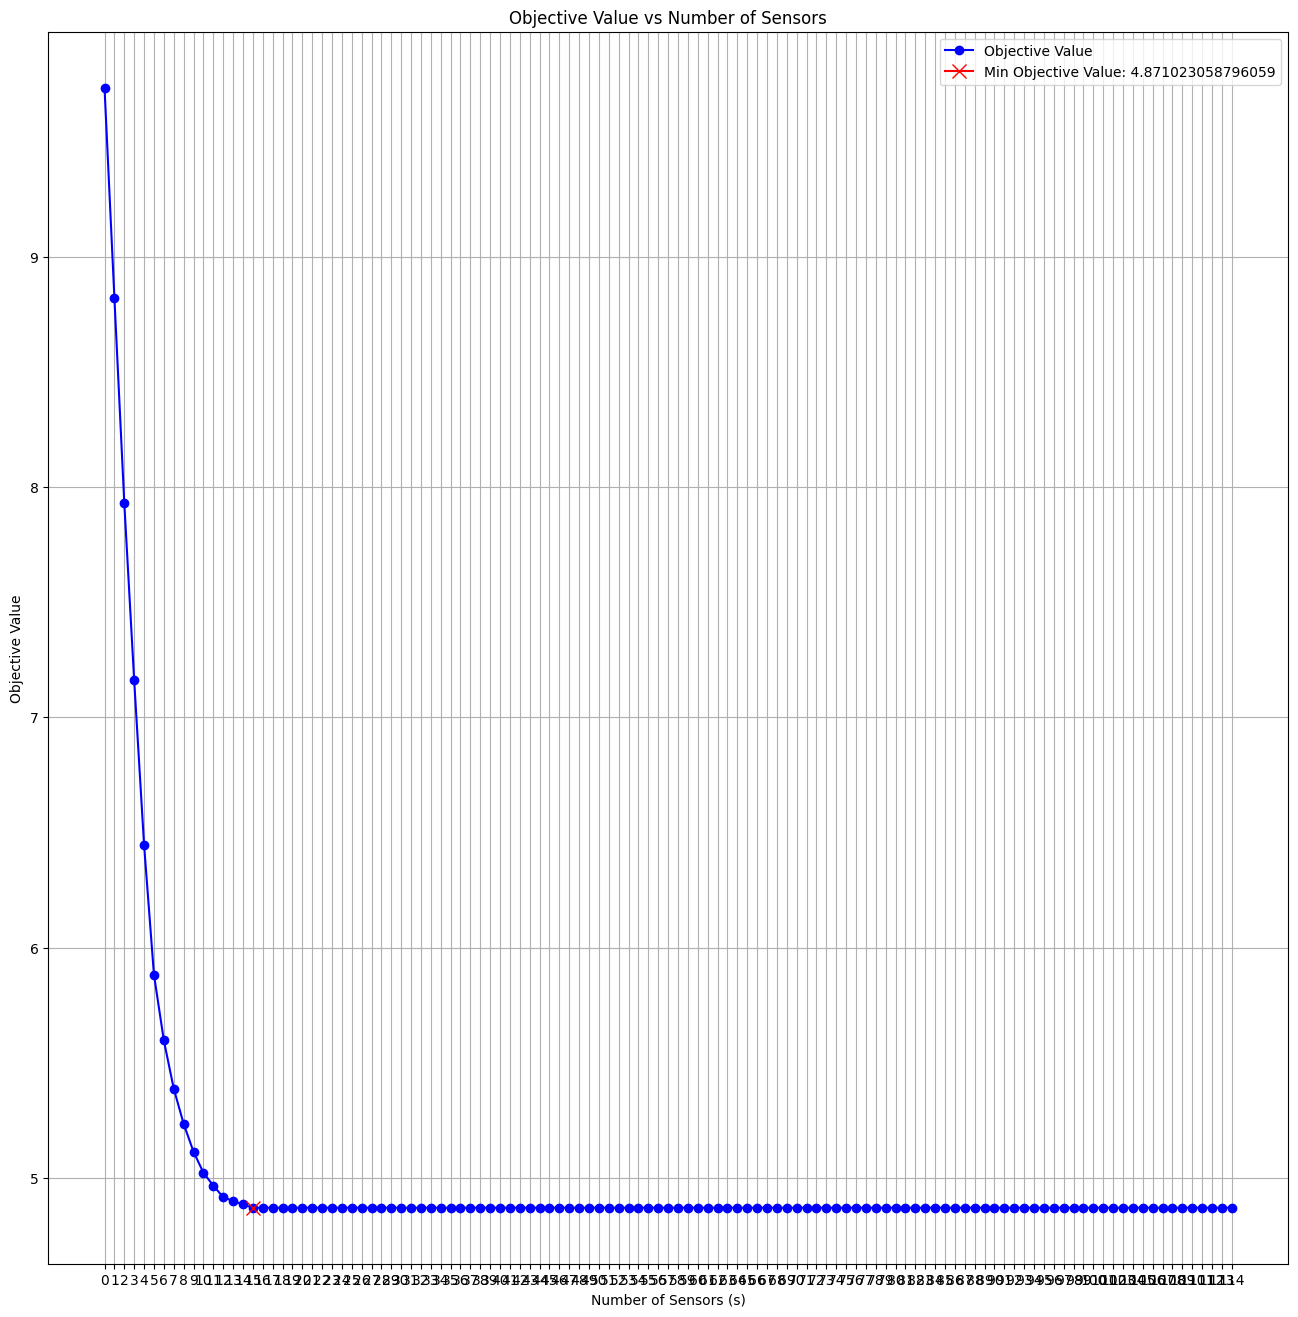

In [17]:
s = list(range(0, len(G.nodes())+1)) # List of feasible number of sensors that can be placed in the WDN
rho = np.sum(np.abs(list(VC.values()))) + 1 # Constant for penalty term for QUBO
objective_value_list_MIP = coverage(G, s, rho)
plot_coverage(s, objective_value_list_MIP)

In [ ]:
# Select optimal parameters from coverage plot results

# Get the number of sensors as the minimum value in the objective_value_list_MIP list
objective_value_list_MIP_min = min(objective_value_list_MIP)
s = objective_value_list_MIP.index(objective_value_list_MIP_min)
print(s)

# s = 15 # Optimal number of sensors
rho = np.sum(np.abs(list(VC.values()))) + 1 # Optimal constant for penalty term for QUBO

model_MIQP = MIQP(G, model, s)
model_QUBO = QUBO(G, model, s, rho)

In [ ]:
model_MIQP.pprint()

In [ ]:
# Solve
solver = pyo.SolverFactory('gurobi', solver_io='python')
results_MIQP = solver.solve(model_MIQP, tee=True) # MIP formulation result

In [ ]:
results_QUBO = solver.solve(model_QUBO, tee=True) # QUBO formulation result

In [ ]:
def sensor_placement_results(model_MIQP, model_QUBO):

    """Prints and returns sensor placement results for MIP and QUBO models.

    This function displays the sensor placement status for each node in both MIP and QUBO models. It provides
    a clear view of which nodes have sensors placed according to each optimization approach. It also returns
    dictionaries with sensor placement information for further analysis.

    Args:
        model_MIQP (pyo.ConcreteModel): The Pyomo model with MIP formulation, including sensor placement variables.
        model_QUBO (pyo.ConcreteModel): The Pyomo model with QUBO formulation, including sensor placement variables.

    Returns:
        tuple: A tuple containing two dictionaries:
            - sensor_placement_MIQP (dict): Dictionary with node names as keys and binary values (0 or 1) indicating
              whether a sensor is placed at each node according to the MIP model.
            - sensor_placement_QUBO (dict): Dictionary with node names as keys and binary values (0 or 1) indicating
              whether a sensor is placed at each node according to the QUBO model.

    Examples:
        >>> sensor_placement_MIQP, sensor_placement_QUBO = sensor_placement_results(model_MIQP, model_QUBO)
        >>> print(sensor_placement_MIQP)
        {'J1': 1, 'J2': 0, 'J3': 1}
        >>> print(sensor_placement_QUBO)
        {'J1': 1, 'J2': 1, 'J3': 0}
    """

    # Print results for MIP
    print("MIP results")
    for node in model_MIQP.nodes:
        print(f"Node {node}: Sensor placed = {pyo.value(model_MIQP.x[node])}")

    sensor_placement_MIQP = {node: pyo.value(model_MIQP.x[node]) for node in model_MIQP.nodes}

    # Print results for QUBO
    print("\nQUBO results")
    for node in model_QUBO.nodes:
        print(f"Node {node}: Sensor placed = {pyo.value(model_QUBO.x[node])}")

    sensor_placement_QUBO = {node: pyo.value(model_QUBO.x[node]) for node in model_QUBO.nodes}

    return sensor_placement_MIQP, sensor_placement_QUBO


In [ ]:
sensor_placement_MIQP, sensor_placement_QUBO = sensor_placement_results(model_MIQP, model_QUBO)

In [ ]:
def plot_sensor_placement(city, sensor_placement, title): # subplot_index, 

    """Plots a city's Water Distribution Network (WDN) and the optimal sensor placement.

    This function visualizes the WDN graph with nodes colored based on sensor placement: red for nodes with
    sensors and sky blue for nodes without. It uses Matplotlib to create the plot and adds a legend to distinguish
    between sensor and non-sensor nodes.

    Args:
        city (str): The name of the city for which the WDN is plotted.
        sensor_placement (dict): A dictionary indicating sensor placement at each node (1 for sensor, 0 for no sensor).
        subplot_index (int): The index of the subplot where the WDN will be plotted (1 or 2).
        title (str): The title of the plot.

    Returns:
        None

    Raises:
        ValueError: If the graph `G` is None.

    Examples:
        >>> plot_sensor_placement('Apulian', {'J1': 1, 'J2': 0, 'J3': 1}, 1, 'Optimal Sensor Placement')
    """

    if G is None:
        print(f"Graph could not be constructed for {city}.")
        return

    pos = nx.get_node_attributes(G, 'pos')

    # Create plot
    # plt.subplot(2, 1, subplot_index)
    plt.plot(1, 1)
    
    # Determine node colors based on sensor placement
    node_colors = ['red' if sensor_placement.get(node, 0) == 1 else 'skyblue' for node in G.nodes()]
    
    nx.draw_networkx_nodes(G, pos, node_size=500, node_color=node_colors)
    nx.draw_networkx_edges(G, pos, edge_color='black')
    #nx.draw_networkx_labels(G, pos, font_size=6, font_color='black')

    # Round off edge and node labels to two decimals for the plot
    edge_labels_rounded = {k: round(v, 2) for k, v in EB.items()}
    node_labels_rounded = {k: round(v, 2) for k, v in VC.items()}

    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels_rounded, label_pos=0.5, font_size=6, verticalalignment='bottom')
    nx.draw_networkx_labels(G, pos, labels=node_labels_rounded, font_size=8, font_color='black')

    # Add legend
    red_patch = Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='Sensor placed')
    blue_patch = Line2D([0], [0], marker='o', color='w', markerfacecolor='skyblue', markersize=10, label='No sensor')
    plt.legend(handles=[red_patch, blue_patch], loc='best', fontsize='24')

    #plt.title(title, fontsize=80)

In [ ]:
def plot_comparison(city, sensor_placement_MIQP, save_path=None): # sensor_placement_QUBO,

    """Plots a city's Water Distribution Network (WDN) with optimal sensor placements from both MIP and QUBO formulations.

    This function generates a single figure with two subplots, showing the WDN with sensor placements obtained
    through the MIP and QUBO models. It utilizes the `plot_sensor_placement` function to visualize the results.

    Args:
        city (str): The name of the city for which the WDN is plotted.
        sensor_placement_MIQP (dict): A dictionary indicating sensor placement at each node from the MIP formulation.
        sensor_placement_QUBO (dict): A dictionary indicating sensor placement at each node from the QUBO formulation.

    Returns:
        None

    Examples:
        >>> plot_comparison('Apulian', {'J1': 1, 'J2': 0, 'J3': 1}, {'J1': 0, 'J2': 1, 'J3': 1})
    """

    # Create the 'plots' directory if it doesn't exist
    if save_path:
        save_dir = os.path.dirname(save_path)
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)

    # Save plot
    if save_path:
        plt.savefig(save_path)

    plt.figure(figsize=(24, 16))

    plot_sensor_placement(city, sensor_placement_MIQP,  f'Optimal Sensor Placement - {city}')

    # plot_sensor_placement(city, sensor_placement_MIQP, 1, f'Sensor Placement - {city} - MIP formulation')
    # plot_sensor_placement(city, sensor_placement_QUBO, 2, f'Sensor Placement - {city} - QUBO formulation')

    # Save plot
    if save_path:
        plt.savefig(save_path)

    plt.show()

In [ ]:
save_path = os.path.join('plots', 'sensor_placement_comparison.png')
plot_comparison(city, sensor_placement_MIQP, save_path=save_path) # sensor_placement_QUBO, 

## Simulated Annealing:
First, we build the adjacency matrix $Q$ that is obtained from the QUBO model. Remember that the QUBO problem is formulated as follows: 
$$
\begin{array}{rl}
    \displaystyle%
    \min_{x} \left( \sum_{i \in V} (c_i + \rho - 2\rho s - \sum_{j \in E} w_{ij})x_i^2 + \sum_{(i,j) \in E} w_{ij}x_i x_j + \rho s^2 + \sum_{(i,j) \in E}{w_{ij}} \right) \\
\end{array}
$$
where $s$ is the total number of sensors that is predefined. And, We know that in general, a QUBO problem is defined as: 
$$
\min_{x \in \{0,1 \}^n} \sum_{(ij) \in E} Q_{ij}x_i x_j + \sum_{i \in V}Q_{ii}x_i + c_Q = \min_{x \in \{0,1 \}^n}  x^\top Q x + c_Q
$$
where we optimize over binary variables $x \in \{ 0,1 \}^n$, on a constrained graph $G(V,E)$ defined by an adjacency matrix $Q$. We also include an arbitrary offset  $c_Q$.


Comparing the above problems, it is evident that 
$$
\begin{array}{rl}
    \displaystyle%
    Q_{ii} = (c_{i} + \rho -2\rho s) - \sum_{j \in V}w_{ij} \\
    
    Q_{ij} = w_{ij} \\ \\

    c_{Q} = \rho s^2 + \sum_{(i,j) \in E}{w_{ij}}
\end{array}
$$\

In [748]:
def build_Q_matrix(G, s):

    """Builds the Q matrix for the Quadratic Unconstrained Binary Optimization (QUBO) problem based on the given graph and model.

    This function constructs the Q adjacency matrix used in QUBO formulations, incorporating vertex costs, edge weights (edge betweenness), and constraints.

    Args:
        G (nx.Graph): The NetworkX graph object representing the water distribution network (WDN).
        model (pyo.ConcreteModel): The Pyomo model with the necessary parameters for QUBO.
        s (int): The number of sensors to be placed.


    Returns:
        tuple: A tuple containing:
            - Q (np.ndarray): The Q matrix for the QUBO problem.
            - cQ (float): The constant term in the QUBO objective function.

    Raises:
        ValueError: If the model is None.

    Examples:
        >>> Q, cQ = build_Q_matrix(G, model, 5)
        >>> print(Q)
        [[ 1.2 -0.5  0. ]
         [-0.5  1.5 -0.3]
         [ 0.  -0.3  1.1]]
        >>> print(cQ)
        2.5
    """

    G = Construct_Graph(city)

    num_nodes = len(G.nodes()) # stores the number of nodes in the graph G
    nodes = list(G.nodes())

    # Correctly create node_costs using node names
    vertex_cost = np.array([VC[node] for node in nodes])
    weight = EB

    # Initialize the constraint matrix A and vector b
    A = np.ones((1, num_nodes))
    print(A)
    b = np.array([s])
    print(b)
    
    # Calculate rho
    #rho = np.sum(np.abs(vertex_cost)) + 1
    rho = 6
    print(rho)
  
    # Add node costs to the diagonal
    Q = np.diag(vertex_cost)
    print(Q)
    print(vertex_cost)
    
    # # Add edge weights to the Q matrix
    total_weight = 0
    print(weight)
    for (i, j), w in weight.items():
        if nodes.index(i) != nodes.index(j):
            Q[nodes.index(i), nodes.index(j)] += w/2
            Q[nodes.index(j), nodes.index(i)] += w/2
        Q[nodes.index(i), nodes.index(i)] -= w
        Q[nodes.index(j), nodes.index(j)] -= w
        total_weight += w
        print(i, j, w)
    print(total_weight)
    print(Q)
    
    # Adjust diagonal with constraints:
    Q += rho*np.matmul(A.T,A)
    print(Q)
    Q -= rho*2*np.diag(np.matmul(b.T,A))
    
    # Calculate constant term cQ 
    cQ = rho * np.matmul(b.T, b) + total_weight
    
    return Q, cQ

In [749]:
s = 11
Q, cQ = build_Q_matrix(G, s)
print("Q matrix:\n", Q , "\n")
print("cQ value:\n", cQ)

[[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]]
[11]
6
[[0.10038062 0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         1.00567108 0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.1333861  0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.13213006 0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.  

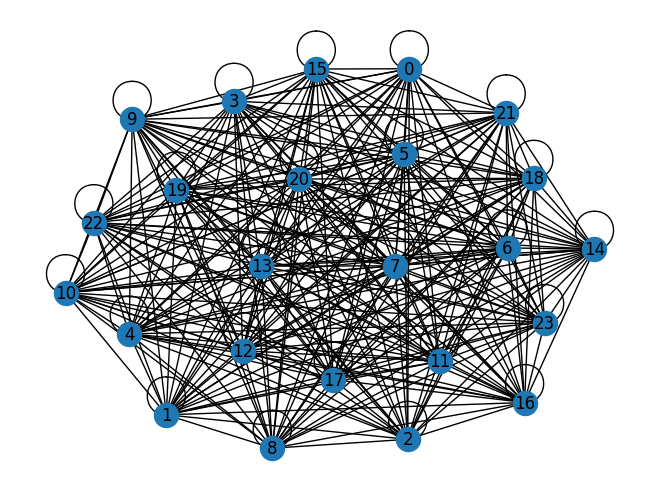

In [750]:
G = nx.from_numpy_matrix(Q)
nx.draw(G, with_labels=True)

In [751]:
# Binary Quadratic model (BQM)

def QUBO_dimod(Q, beta):

    """Creates a Binary Quadratic Model (BQM) from a Q matrix and an offset.

    This function constructs a BQM, which is used for solving quadratic optimization problems using binary variables.
    It uses the `dimod` library to create the model from the Q adjacency matrix and an offset value, preparing it for use with
    optimization solvers.

    Args:
        Q (np.ndarray): The Q matrix representing the quadratic terms in the optimization problem.
        beta (float): The offset value for the BQM.

    Returns:
        dimod.BinaryQuadraticModel: The Binary Quadratic Model constructed from the Q matrix and offset.

    Examples:
        >>> Q = np.array([[1, -1], [-1, 2]])
        >>> beta = 0.5
        >>> bqm = QUBO_dimod(Q, beta)
        >>> print(bqm)
        BinaryQuadraticModel({0: 1, 1: -1}, {(0, 1): -1}, 0.5, dimod.BINARY)
    """

    # Binary Quadratic Model
    bqm = dimod.BinaryQuadraticModel.from_qubo(Q, offset = beta) 
    
    return bqm

In [752]:
bqm = QUBO_dimod(Q, beta=cQ) # returns bqm value
print(bqm)

# # Use ExactSolver to sample the BQM
# exactSampler = dimod.reference.samplers.ExactSolver()
# exactSamples = exactSampler.sample(bqm)

# # Print the sample results
# print("Exact Solver Samples:")
# print(exactSamples)

# # If you want to extract and process the samples:
# for sample, energy in exactSamples.data(['sample', 'energy']):
#     print(sample, "Energy:", energy)

BinaryQuadraticModel({0: -126.3545710733974, 1: -125.32005356017643, 2: -126.31613080772306, 3: -126.18610665973816, 4: -126.20907574779126, 5: -126.44926286740845, 6: -126.26826571108613, 7: -126.34836653896397, 8: -126.27453902948842, 9: -126.06842978248731, 10: -126.07582248739433, 11: -126.03958628827021, 12: -126.15768884952915, 13: -126.17263272726929, 14: -126.11090775804404, 15: -126.1814804781892, 16: -126.107322097442, 17: -126.07097637099676, 18: -126.12521820368933, 19: -126.08858271104475, 20: -126.11218836571088, 21: -126.23029741693269, 22: -126.0755005884129, 23: -125.9886237934142}, {(1, 0): 12.152596618357489, (2, 0): 12.0, (2, 1): 12.130253623188405, (3, 0): 12.0, (3, 1): 12.042874396135266, (3, 2): 12.114432367149758, (4, 0): 12.095712560386474, (4, 1): 12.0, (4, 2): 12.0, (4, 3): 12.0, (5, 0): 12.0, (5, 1): 12.0, (5, 2): 12.0, (5, 3): 12.160929951690822, (5, 4): 12.135265700483092, (6, 0): 12.0, (6, 1): 12.0, (6, 2): 12.0, (6, 3): 12.0, (6, 4): 12.0, (6, 5): 12.159

In [753]:
# Some useful functions to get plots
def plot_enumerate(results, title=None):

    plt.figure()

    energies = [datum.energy for datum in results.data(
        ['energy'], sorted_by='energy')]

    if results.vartype == 'Vartype.BINARY':
        samples = [''.join(c for c in str(datum.sample.values()).strip(
            ', ') if c.isdigit()) for datum in results.data(['sample'], sorted_by=None)]
        plt.xlabel('bitstring for solution')
    else:
        samples = np.arange(len(energies))
        plt.xlabel('solution')

    plt.bar(samples,energies)
    plt.xticks(rotation=90)
    plt.ylabel('Energy')
    plt.title(str(title))
    print("minimum energy:", min(energies))

def plot_samples(results, title=None):
    plt.figure()
    if results.vartype == 'Vartype.BINARY':
        samples = [''.join(c for c in str(datum.sample.values()).strip(
            ', ') if c.isdigit()) for datum in results.data(['sample'], sorted_by=None)]
        plt.xlabel('bitstring for solution')
    else:
        samples = np.arange(len(energies))
        plt.xlabel('solution')

    counts = Counter(samples)
    total = len(samples)
    for key in counts:
        counts[key] /= total
    df = pd.DataFrame.from_dict(counts, orient='index').sort_index()
    df.plot(kind='bar', legend=None)

    plt.xticks(rotation=80)
    plt.ylabel('Probabilities')
    plt.title(str(title))
    plt.show()
    print("minimum energy:", min(energies))


def plot_energies(results, title=None, skip=1):
    # skip parameter given to avoid putting all xlabels
    energies = results.data_vectors['energy']
    occurrences = results.data_vectors['num_occurrences']
    counts = Counter(energies)
    total = sum(occurrences)
    counts = {}
    for index, energy in enumerate(energies):
        if energy in counts.keys():
            counts[energy] += occurrences[index]
        else:
            counts[energy] = occurrences[index]
    for key in counts:
        counts[key] /= total
    df = pd.DataFrame.from_dict(counts, orient='index').sort_index()
    ax = df.plot(kind='bar', legend=None)

    plt.xlabel('Energy')
    plt.ylabel('Probabilities')
    # Plot only a subset of xlabels (every skip steps)
    ax.set_xticklabels([t if not i%skip else "" for i,t in enumerate(ax.get_xticklabels())])
    plt.title(str(title))
    plt.show()
    print("minimum energy:", min(energies))

Total time for Simulated Annealing: 4.253857851028442
minimum energy: 1.4605239847898375


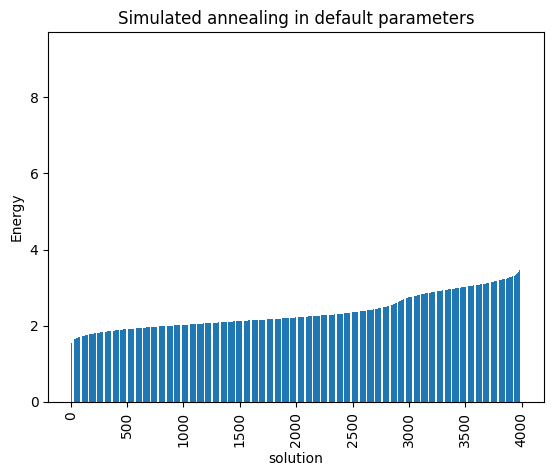

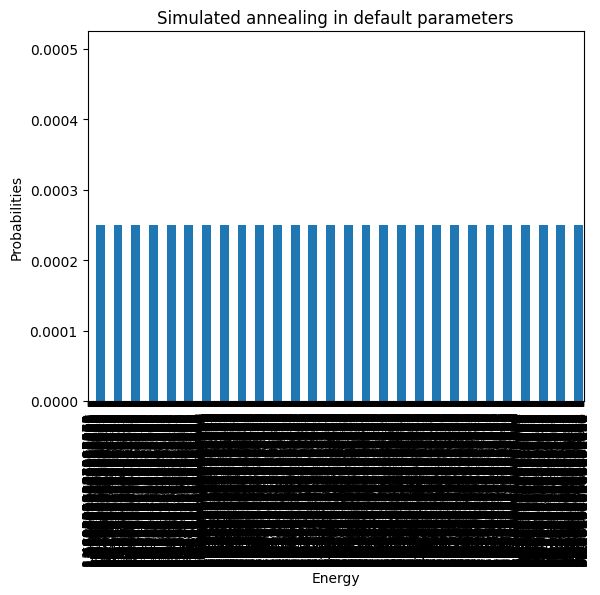

minimum energy: 1.4605239847898375


{'beta_range': [0.004590206285724082, 1.2972040027226728],
 'beta_schedule_type': 'geometric',
 'timing': {'preprocessing_ns': 22334717,
  'sampling_ns': 4229428048,
  'postprocessing_ns': 1101912}}

In [754]:
# Simulated Annealing 
mod = bqm
simAnnSampler = neal.SimulatedAnnealingSampler()
start_SA = time.time()
simAnnSamples = simAnnSampler.sample(mod, num_reads=4000)
end_SA = time.time()
total_time_SA = end_SA - start_SA
print("Total time for Simulated Annealing:", total_time_SA)
plot_enumerate(simAnnSamples, title='Simulated annealing in default parameters')
plot_energies(simAnnSamples, title='Simulated annealing in default parameters')
simAnnSamples.info

Total time for Tabu search: 84.37239122390747
minimum energy: 1.3001818593050416


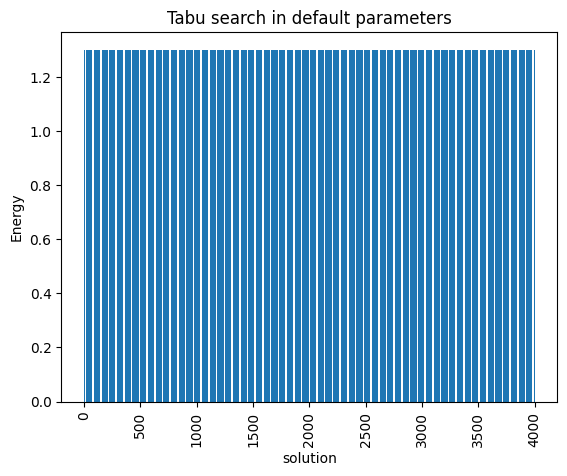

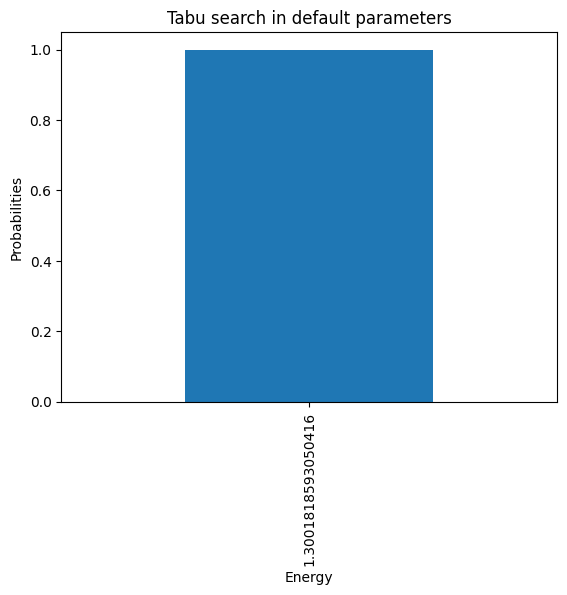

minimum energy: 1.3001818593050416


{}

In [755]:
# Tabu search
start_tabu = time.time()
sampleset_tabu = TabuSampler().sample(mod, num_reads=4000)
end_tabu = time.time()
total_time_tabu = end_tabu - start_tabu
print("Total time for Tabu search:", total_time_tabu)
plot_enumerate(sampleset_tabu, title='Tabu search in default parameters')
plot_energies(sampleset_tabu, title='Tabu search in default parameters')
sampleset_tabu.info

In [693]:
# plot_enumerate(exactSamples, title='Enumerate all solutions')
# plot_energies(exactSamples, title='Enumerate all solutions', skip=10)

In [756]:
# print(simAnnSamples)
# print(simAnnSamples.data)
SimAnn_samples_Aggregate = simAnnSamples.aggregate()
print(SimAnn_samples_Aggregate)

      0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 ... 23   energy num_oc.
1541  1  0  1  0  1  1  0  1  1  0  0  0  1  0  1  1  0 ...  0 1.460524       1
1207  1  0  0  1  0  1  0  1  1  0  0  1  0  0  1  0  1 ...  0 1.484534       1
1159  1  0  1  0  0  1  0  1  1  0  0  0  1  0  1  0  1 ...  0 1.488214       1
2059  1  0  1  0  1  1  0  1  0  0  1  0  1  1  1  0  0 ...  0 1.512896       1
2989  1  0  1  0  0  1  1  1  0  0  1  0  1  0  1  0  1 ...  0 1.515197       1
1513  1  0  1  0  1  1  0  1  1  0  0  1  1  0  1  0  0 ...  0 1.524827       1
921   1  0  1  0  1  1  0  1  0  0  1  0  1  0  1  1  0 ...  0 1.542366       1
3323  1  0  1  0  0  1  0  1  1  1  0  1  0  1  0  1  0 ...  0 1.549094       1
3751  1  0  0  0  1  1  0  1  1  0  0  0  1  0  1  1  1 ...  0 1.558705       1
3981  1  0  1  0  1  1  0  1  1  0  0  1  1  0  0  1  0 ...  0  1.56917       1
2294  1  0  1  0  0  1  1  0  1  0  1  1  0  1  0  0  1 ...  0 1.570456       1
2303  1  0  1  0  0  1  0  1  0  1  1  1

In [757]:
# print(sampleset_tabu)
# print(sampleset_tabu.data)
sampleset_tabu_Aggregate = sampleset_tabu.aggregate()
print(sampleset_tabu_Aggregate)

   0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 ... 23   energy num_oc. ...
0  1  0  1  0  0  1  0  1  0  0  1  0  1  0  1  0 ...  0 1.300182    4000 ...
['BINARY', 1 rows, 4000 samples, 24 variables]


## Quantum Annealing via D-Wave:
This is the first interaction with D-Wave's Quantum Annealer. It will use the QUBO model introduced earlier and will define it using D-Wave's package dimod, and then solve them using neal's implementation of simulated annealing classicaly and D-Wave system package to use Quantum Annealing. We will also leverage the use of Networkx for network models/graphs.


In [763]:
# Import DWave
import dwave_networkx as dnx
from dwave.system import (DWaveSampler, EmbeddingComposite,
                          FixedEmbeddingComposite)
from pprint import pprint
from dwave.system import LeapHybridSampler


Advantage_system4.1
Number of qubits= 5627
Number of couplers= 40279
Total time for Quantum Annealing: 0.48003292083740234
{'timing': {'qpu_sampling_time': 415120.0, 'qpu_anneal_time_per_sample': 20.0, 'qpu_readout_time_per_sample': 63.2, 'qpu_access_time': 430882.36, 'qpu_access_overhead_time': 2924.64, 'qpu_programming_time': 15762.36, 'qpu_delay_time_per_sample': 20.58, 'total_post_processing_time': 1.0, 'post_processing_overhead_time': 1.0}, 'problem_id': '4b141a3a-ae13-4b3f-9b17-624fb8f45938', 'embedding_context': {'embedding': {1: (1802, 3099, 1801), 0: (1742, 3084, 1741, 1740), 2: (1606, 3294, 3293), 3: (3310, 3308, 3309), 4: (1681, 3234, 3233), 5: (3325, 1771, 3323, 3324), 6: (1546, 3340, 3339, 1607, 3338), 7: (3203, 3204, 1637, 1636), 8: (1757, 1756, 3159), 9: (1727, 1725, 1726), 10: (3355, 1531, 3354, 3353), 11: (1891, 3218, 3219), 12: (1875, 3368, 3369, 1876), 13: (3129, 1652, 1651), 14: (1712, 1711, 1710), 15: (3383, 1832, 3384), 16: (1696, 3144, 1695), 17: (1561, 3264, 183

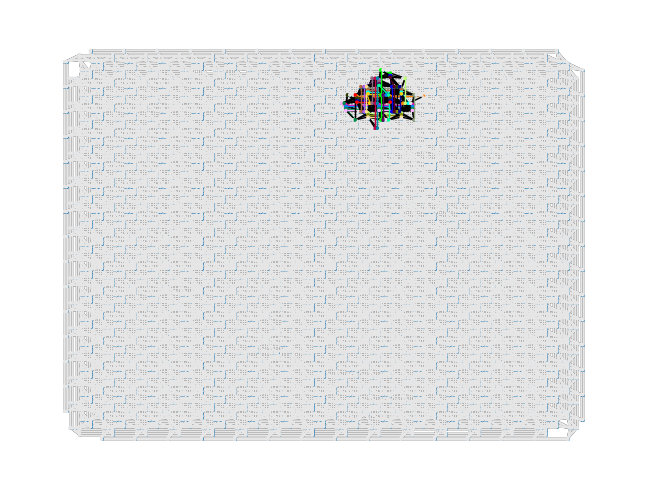

In [764]:
# Graph corresponding to D-Wave Model
qpu = DWaveSampler()
qpu_edges = qpu.edgelist
qpu_nodes = qpu.nodelist
# pprint(dir(qpu))
if qpu.solver.id == "DW_2000Q_6":
    print(qpu.solver.id)
    X = dnx.chimera_graph(16, node_list=qpu_nodes, edge_list=qpu_edges)
    dnx.draw_chimera(X, node_size=1)
    print('Number of qubits=', len(qpu_nodes))
    print('Number of couplers=', len(qpu_edges))
else:
    print(qpu.solver.id)
    X = dnx.pegasus_graph(16, node_list=qpu_nodes, edge_list=qpu_edges)
    dnx.draw_pegasus(X, node_size=1)
    print('Number of qubits=', len(qpu_nodes))
    print('Number of couplers=', len(qpu_edges))

DWavesampler = EmbeddingComposite(DWaveSampler())
start_QA = time.time()
DWaveSamples = DWavesampler.sample(bqm, num_reads=4000, 
                                   return_embedding=True, 
                                  #  chain_strength=chain_strength, 
                                  #  annealing_time=annealing_time
)
end_QA = time.time()
total_time_QA = end_QA - start_QA
print("Total time for Quantum Annealing:", total_time_QA)
print(DWaveSamples.info)
embedding = DWaveSamples.info['embedding_context']['embedding']
if qpu.solver.id == "DW_2000Q_6":
  dnx.draw_chimera_embedding(X, embedding, node_size=2)
else:
  dnx.draw_pegasus_embedding(X, embedding, node_size=2)

minimum energy: 1.8833073480869729


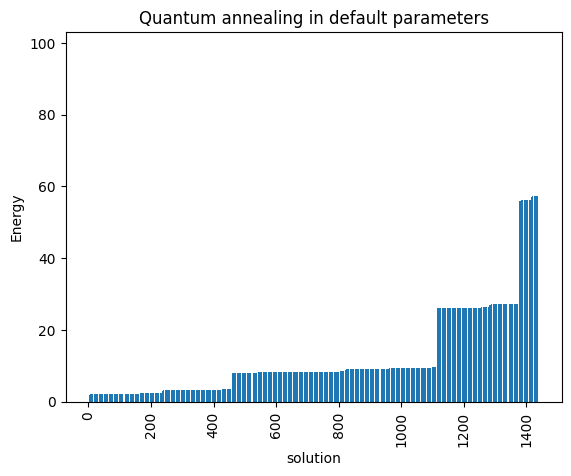

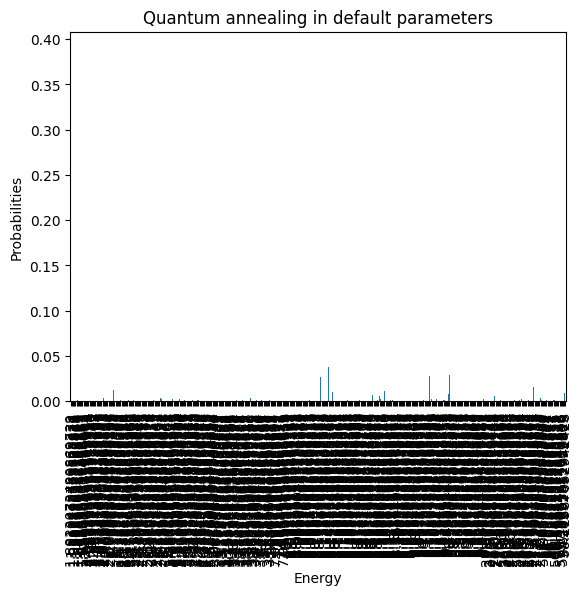

minimum energy: 1.8833073480869729


In [765]:
plot_enumerate(DWaveSamples, title='Quantum annealing in default parameters')
plot_energies(DWaveSamples, title='Quantum annealing in default parameters')

In [766]:
# print(DWaveSamples)
# print(DWaveSamples.data)
DWave_Aggregate = DWaveSamples.aggregate()
print(DWave_Aggregate)

     0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 ... 23    energy num_oc. ...
337  0  0  1  1  0  1  0  1  0  0  1  1  1  0  0 ...  0  1.883307       1 ...
86   0  0  1  1  0  1  0  0  0  0  1  0  1  1  0 ...  0   1.91048       1 ...
357  0  0  1  1  1  1  1  1  0  0  1  0  1  0  0 ...  0  1.916381       1 ...
99   0  0  1  1  0  1  0  1  0  0  1  0  1  0  0 ...  0  1.921219       2 ...
249  0  0  1  1  1  0  1  1  0  0  1  0  0  0  0 ...  0   1.95358       1 ...
147  0  0  1  1  1  0  1  1  0  0  1  1  0  0  0 ...  0  1.955678       1 ...
29   0  0  1  1  1  1  1  0  0  0  1  0  0  0  0 ...  0  1.978617       4 ...
266  0  0  1  0  1  0  1  1  0  0  1  1  1  0  0 ...  0  1.979895       1 ...
334  1  0  0  0  0  1  1  0  0  0  0  0  1  1  0 ...  0  1.991009       1 ...
403  0  0  1  1  1  1  0  1  0  0  1  1  1  0  0 ...  0  1.992036       1 ...
261  0  0  1  1  0  1  1  0  0  0  1  0  0  0  0 ...  0  1.992588       1 ...
30   0  0  1  1  0  1  1  0  0  0  1  1  0  0  0 ...  0  1.99605

In [767]:
rho

4.472717911486662

In [768]:
# Leap Hybrid Solver
sampler = LeapHybridSampler(solver={'category': 'hybrid'})
sampleset_Leap = sampler.sample(bqm)
sampleset_Leap.info  

{'qpu_access_time': 140127,
 'charge_time': 2995102,
 'run_time': 2995102,
 'problem_id': 'd06e9931-ee60-40b1-b8b4-cde9bab66e73'}

In [769]:
sampleset_Leap_Aggregate = sampleset_Leap
print(sampleset_Leap_Aggregate)

   0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 ... 23   energy num_oc.
0  1  0  1  0  0  1  0  1  0  0  1  1  0  0  1  0  1  1 ...  0 1.471847       1
['BINARY', 1 rows, 1 samples, 24 variables]


minimum energy: 1.4718472224963364


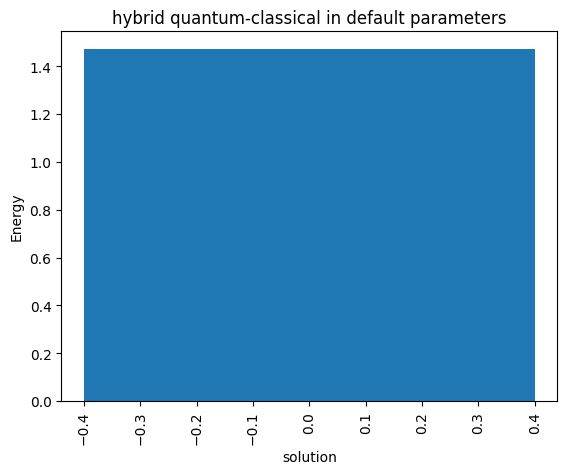

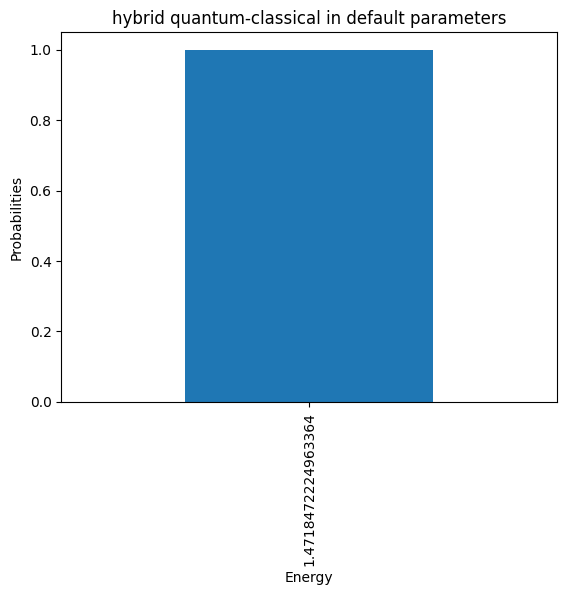

minimum energy: 1.4718472224963364


In [770]:
plot_enumerate(sampleset_Leap, title='hybrid quantum-classical in default parameters')
plot_energies(sampleset_Leap, title='hybrid quantum-classical in default parameters')

In [771]:
# Aggregate the samples
sampleset_Leap_Aggregate = sampleset_Leap.aggregate()
print(sampleset_Leap_Aggregate)
DWave_Aggregate = DWaveSamples.aggregate()
print(DWave_Aggregate)
simAnnSamples_Aggregate = simAnnSamples.aggregate()
print(simAnnSamples_Aggregate)
sampleset_tabu_Aggregate = sampleset_tabu.aggregate()
print(sampleset_tabu_Aggregate)


   0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 ... 23   energy num_oc.
0  1  0  1  0  0  1  0  1  0  0  1  1  0  0  1  0  1  1 ...  0 1.471847       1
['BINARY', 1 rows, 1 samples, 24 variables]
     0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 ... 23    energy num_oc. ...
337  0  0  1  1  0  1  0  1  0  0  1  1  1  0  0 ...  0  1.883307       1 ...
86   0  0  1  1  0  1  0  0  0  0  1  0  1  1  0 ...  0   1.91048       1 ...
357  0  0  1  1  1  1  1  1  0  0  1  0  1  0  0 ...  0  1.916381       1 ...
99   0  0  1  1  0  1  0  1  0  0  1  0  1  0  0 ...  0  1.921219       2 ...
249  0  0  1  1  1  0  1  1  0  0  1  0  0  0  0 ...  0   1.95358       1 ...
147  0  0  1  1  1  0  1  1  0  0  1  1  0  0  0 ...  0  1.955678       1 ...
29   0  0  1  1  1  1  1  0  0  0  1  0  0  0  0 ...  0  1.978617       4 ...
266  0  0  1  0  1  0  1  1  0  0  1  1  1  0  0 ...  0  1.979895       1 ...
334  1  0  0  0  0  1  1  0  0  0  0  0  1  1  0 ...  0  1.991009       1 ...
403  0  0  1  1 

In [772]:
# Pands Dataframes of the samples
def sampleset_to_df(results, skip=1, imported=False):
    """
    Convert the results of the optimization to a dataframe.

    Parameters
    ----------
    results : dimod.exactSampler.sample or neal.sampler.SimulatedAnnealingSampler.sample
        The results of the optimization.
    skip : int, optional
        parameter to avoid putting all xlabels, by default 1
    """
    # skip parameter given to avoid putting all xlabels

    if imported:
        energies = results['energy']
        occurrences = results['num_occurrences']
    else:
        energies = results.data_vectors['energy']
        occurrences = results.data_vectors['num_occurrences']

    counts = Counter(energies)
    total = sum(occurrences)
    counts = {}
    for index, energy in enumerate(energies):
        if energy in counts.keys():
            counts[energy] += occurrences[index]
        else:
            counts[energy] = occurrences[index]
    for key in counts:
        counts[key] /= total
    df = pd.DataFrame.from_dict(counts, orient='index').sort_index()

    # index is the energy, the column is the probability
    df.columns = ['Probability']
    df.index.name = 'Energy'
    
    return df

In [773]:
df_DWave = sampleset_to_df(DWave_Aggregate)
df_Leap = sampleset_to_df(sampleset_Leap_Aggregate)
df_SA = sampleset_to_df(simAnnSamples_Aggregate)
df_tabu = sampleset_to_df(sampleset_tabu_Aggregate)
print(df_Leap)

          Probability
Energy               
1.471847     1.000000


In [774]:
def sum_infeas_soln(df, threshold): 
    """
    Consolidate the infeasible solutions in the results dataframe.

    Parameters
    ----------
    df : pd.DataFrame
        The results of the optimization.
    threshold : float
        The energy threshold for the optimal or feasible solution.
    """
    
    infeasible = df[df.index > threshold]
    infeasible_sum = infeasible.sum()
    infeasible_sum.name = threshold
    df = df[df.index <= threshold]
    df = pd.concat([df, infeasible_sum.to_frame().T])
    return df

In [775]:
threshold = rho + 1
filtered_df_Leap = sum_infeas_soln(df_Leap, threshold)
filtered_df_DWave = sum_infeas_soln(df_DWave, threshold)
filtered_df_SA = sum_infeas_soln(df_SA, threshold)
filtered_df_tabu = sum_infeas_soln(df_tabu, threshold)

In [781]:
def plot_multibar_graph_discrete(df_list, df_names, df_colors, vertical_line=None, skip=1, title=None, round_decimals=2, bin_size=0.1):
    """
    Plot the multibar graph of the results of the optimization with discrete (evenly spaced) x-axis,
    ensuring unique energy levels with rounding and binning, and leaving gaps for large differences in integer parts.

    Parameters
    ----------
    df_list : list of pd.DataFrame
        The list of dataframes to plot.
    df_names : list of str
        The names of the dataframes.
    df_colors : list of str
        The bar colors of the dataframes.
    vertical_line : float, optional
        The energy level to plot a vertical line at, by default None.
    skip : int, optional
        The number of x-ticks to skip, by default 1.
    title : str, optional
        The plot title, by default None.
    round_decimals : int, optional
        The number of decimal places to round the energy levels to, by default 2.
    bin_size : float, optional
        The size of each bin to aggregate energy levels, by default 0.1.
    """

    # Bin energy levels in all DataFrames
    binned_dfs = [bin_energy_levels(df, bin_size, round_decimals) for df in df_list]

    # Combine all energy levels (treat as discrete categories)
    energy_levels = sorted(set.union(*(set(df.index) for df in binned_dfs)))

    # Adjust for large gaps between integer parts of energy levels
    adjusted_energy_levels = []
    prev_level = None
    gap_threshold = 1  # Threshold for gaps between integer parts

    # Create artificial gaps
    for level in energy_levels:
        if prev_level is not None:
            if int(level) - int(prev_level) >= gap_threshold:
                # Introduce a gap by adding a space in the adjusted levels
                adjusted_energy_levels.append(prev_level + (level - prev_level) / 2)  # Add midpoint as gap marker
        adjusted_energy_levels.append(level)
        prev_level = level

    # Merge dataframes for common energy levels
    unique_dfs = []
    for df in binned_dfs:
        # Align the DataFrame with the global adjusted_energy_levels and fill missing with 0
        aligned_df = pd.DataFrame({'Energy': adjusted_energy_levels}).set_index('Energy').join(df, how='left').fillna(0)
        unique_dfs.append(aligned_df)

    width = 0.8 / len(df_list)  # Adjust width to avoid overlap

    # Convert energy levels to discrete positions (0, 1, 2, ..., len(adjusted_energy_levels)-1)
    pos = np.arange(len(adjusted_energy_levels))

    fig, ax = plt.subplots(figsize=(18, 8))

    # Plotting the bars at discrete positions
    for i, (df, name, color) in enumerate(zip(unique_dfs, df_names, df_colors)):
        ax.bar(pos + i * width, df['Probability'], width, alpha=0.7, color=color, label=name)

    # Add dashed vertical line at specified energy level if provided
    if vertical_line is not None:
        binned_vertical_line = round(vertical_line // bin_size * bin_size, round_decimals)
        if binned_vertical_line in adjusted_energy_levels:
            ax.axvline(x=adjusted_energy_levels.index(binned_vertical_line), color='black', linestyle='--', label='Gurobi')

    # Add a vertical line before infeasibility starts 
    ax.axvline(x=adjusted_energy_levels.index(7.9), color='orange', linestyle='--', label='Feasibility Boundary')

    # Set the y-axis scale to logarithmic
    ax.set_yscale('log')
    # Set the y-axis label
    ax.set_ylabel('Probability', fontsize=18)  # Increased font size for y-axis label
    ax.set_xlabel('Objective Value', fontsize=18)  # Increased font size for x-axis label

    # Set y-axis limit to 10^0
    ax.set_ylim(1e-5, 1e0)  # Adjust if needed to ensure the minimum limit is visible

    xtick_labels = [f"{e:.2f}" if i % skip == 0 else "" for i, e in enumerate(adjusted_energy_levels)]
    
    ax.set_xticks(pos)
    ax.set_xticklabels(xtick_labels, rotation=90, fontsize=16)  # Increased font size for x-tick labels

    ax.tick_params(axis='y', labelsize=16)  # Increased font size for y-tick labels

    # Modify the legend to be in a single row with increased font size
    plt.legend(loc='upper center', ncol=len(df_list), fontsize=15)

    plt.show()


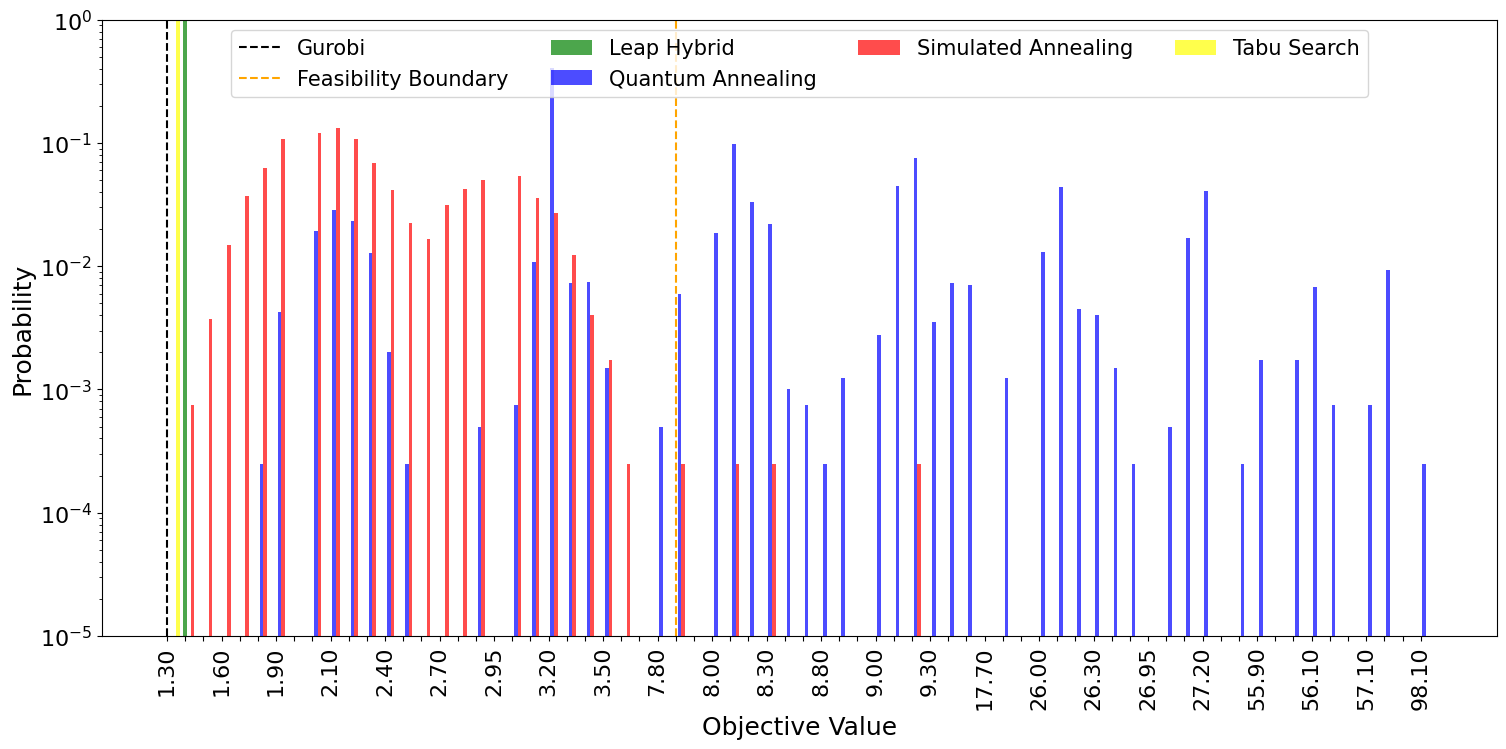

In [782]:
# df_list = [filtered_df_Leap, filtered_df_DWave, filtered_df_SA, filtered_df_tabu]
df_list = [df_Leap, df_DWave, df_SA, df_tabu]
df_names = ['Leap Hybrid', 'Quantum Annealing', 'Simulated Annealing', 'Tabu Search']
df_colors = ['green', 'blue', 'red', 'yellow']
plot_multibar_graph_discrete(df_list, df_names, df_colors, vertical_line=1.300181859305, skip = 3, title='Comparison of Optimization Results')

## Time To Solution (TTS):
We would like to obtain a large probability of finding a right solution (the definition of right comes from what you define as success). On the other hand, the time it takes to solve these cases should be as small as possible. Therefore we are interested in a metric that combines both, and is called the Time To Solution (TTS) which is defined as
$$
TTS = T_{single run} * \frac{\log({1-s})}{\log({1-p})}
$$
where s is a success factor, and taken as $s = 99\%$, while $p$ is the success probability, usually accounted as the observed success probability.

One usually reads this as the time to solution within 99\% probability.


In [783]:
# def calculate_tts(samples, s, min_energy, TT):
#     """
#     Calculates the Time-to-Solution (TTS) for a given set of samples.

#     Args:
#         samples (iterable): A collection of samples, each containing a 'sample', 
#                             'energy', and 'num_occurrences'.
#         s (int): The expected total size for feasible solutions.
#         energy_threshold (float): The energy threshold below which a solution is 
#                                   considered optimal.
#         total_time (float): The total time used for calculations, typically representing 
#                             the time taken to run the optimization process.

#     Returns:
#         tuple: A tuple containing the following:
#             - p_opt (float): The probability of finding an optimal solution.
#             - p_fea (float): The probability of finding a feasible solution.
#             - TTS_opt (float): The Time-to-Solution for finding an optimal solution.
#             - TTS_fea (float): The Time-to-Solution for finding a feasible solution.

#     Example:
#         tts_results = calculate_tts(simAnnSamples.data(['sample', 'energy', 'num_occurrences']), 10, 2.68, total_time)
#     """
#     p_opt = 0
#     p_fea = 0
    
#     # Convert the generator to a list if needed
#     samples_data = list(samples)
#     total_samples = len(samples_data)
    
#     # Calculate total occurrences for feasible and optimal samples
#     for sample, energy, num_ocu in samples_data:
#         total_size = sum(sample.values())
#         if total_size == s:
#             print(total_size)
#             p_fea += num_ocu
#             if energy <= min_energy + 1e-6:
#                 p_opt += num_ocu

#     # Normalize by the total number of samples
#     p_opt /= total_samples
#     p_fea /= total_samples

#     # Calculate TTS values
#     TTS_opt = TT * np.log(1 - 0.99) / np.log(1 - p_opt)
#     TTS_fea = TT * np.log(1 - 0.99) / np.log(1 - p_fea)

#     return p_opt, p_fea, TTS_opt, TTS_fea

In [784]:
def calculate_tts(sample_set, s, energy_threshold, exec_time): 
    """
    Calculate the time to solution (optimality or feasibility) for the simulated annealing solver.

    Parameters
    ----------
    dist_sim : dimod.SampleSet
        The samples returned by the simulated or quantum annealing solver.    
    exec_time : float
        The execution time of the simulated or quantum annealing solver.
    energy_threshold : float
        The energy threshold for the optimal or feasible solution.
    s : float, optional
        The success probability, by default 0.99
    """

    # dist = sample_set.aggregate()
    samples_data = list(sample_set)
    tts = exec_time
    total_size = s

    # Define probability of finding solution in dist with energy <= energy_threshold 
    p_opt = 0
    p_fea = 0
    n = 0 # total number of samples

    for sample, energy, num_ocu in samples_data:
        #print(sample, energy, num_ocu)
        total_size = sum(sample.values())
        print(total_size, energy)
        if total_size == s:
            p_fea += num_ocu
            print(p_fea)
        if energy <= energy_threshold:
            p_opt += num_ocu

        n += num_ocu
        
    # Normalize the probability
    p_opt = p_opt/n
    p_fea = p_fea/n
    print(f'Probability of optimal solution <= {energy_threshold} : {p_opt}')
    print(f'Probability of feasible solution sataisfying constraints : {p_fea}')

    # Compute time to solution for optimal solution
    if p_opt == 1:
        TTS_opt = tts
    elif p_opt == 0:
        TTS_opt = np.inf
    else:
        TTS_opt = tts*np.log(1 - 0.99)/np.log(1 - p_opt)

    # Compute time to solution for feasible solution
    if p_fea == 1:
        TTS_fea = tts
    elif p_fea == 0:
        TTS_fea = np.inf
    else:
        TTS_fea = tts*np.log(1 - 0.99)/np.log(1 - p_fea)

    print(f'Time to solution for optimal solution : {TTS_opt}')
    print(f'Time to solution for feasible solution : {TTS_fea}')

In [780]:
# TTS for Simulated Annealing samples
tts_results_SA = calculate_tts(simAnnSamples.data(['sample', 'energy', 'num_occurrences']), 11, 1.3131, total_time_SA)
print(tts_results_SA)

11 1.4605239847898375
1
11 1.484534265542834
2
11 1.4882143824107672
3
11 1.5128957294427252
4
11 1.5151972685965873
5
11 1.5248270127963153
6
11 1.5423661906034098
7
11 1.549094124201126
8
11 1.5587046757472152
9
11 1.5691697515883405
10
11 1.5704560071040063
11
11 1.570621068681291
12
11 1.5762319175108317
13
11 1.5783659886306296
14
11 1.5790836559997743
15
11 1.581703334705388
16
11 1.582704455402201
17
11 1.5936194474881162
18
11 1.6011124386261528
19
11 1.6086308094816317
20
11 1.6155604800269003
21
11 1.6169140923279883
22
11 1.617786644701404
23
11 1.618677551832043
24
11 1.6203893990638107
25
11 1.6216050074069415
26
11 1.6229881483480781
27
11 1.6231088805105642
28
11 1.6251918665935747
29
11 1.6264344661075185
30
11 1.6282670795560392
31
11 1.6300193243478773
32
11 1.6354354916551515
33
11 1.6469967238750982
34
11 1.647542044655836
35
11 1.6491467926941326
36
11 1.650337825790153
37
11 1.651681452922098
38
11 1.656190711765305
39
11 1.6565610565104762
40
11 1.656671505405619

In [785]:
# TTS for Tabu Search samples
tts_results_Tabu = calculate_tts(sampleset_tabu.data(['sample', 'energy', 'num_occurrences']), 11, 1.3131, total_time_tabu)
print(tts_results_Tabu)

11 1.3001818593050416
1
11 1.3001818593050416
2
11 1.3001818593050416
3
11 1.3001818593050416
4
11 1.3001818593050416
5
11 1.3001818593050416
6
11 1.3001818593050416
7
11 1.3001818593050416
8
11 1.3001818593050416
9
11 1.3001818593050416
10
11 1.3001818593050416
11
11 1.3001818593050416
12
11 1.3001818593050416
13
11 1.3001818593050416
14
11 1.3001818593050416
15
11 1.3001818593050416
16
11 1.3001818593050416
17
11 1.3001818593050416
18
11 1.3001818593050416
19
11 1.3001818593050416
20
11 1.3001818593050416
21
11 1.3001818593050416
22
11 1.3001818593050416
23
11 1.3001818593050416
24
11 1.3001818593050416
25
11 1.3001818593050416
26
11 1.3001818593050416
27
11 1.3001818593050416
28
11 1.3001818593050416
29
11 1.3001818593050416
30
11 1.3001818593050416
31
11 1.3001818593050416
32
11 1.3001818593050416
33
11 1.3001818593050416
34
11 1.3001818593050416
35
11 1.3001818593050416
36
11 1.3001818593050416
37
11 1.3001818593050416
38
11 1.3001818593050416
39
11 1.3001818593050416
40
11 1.3001

In [786]:
# TTS for Leap Hybrid Solver samples
total_time_Leap = sampleset_Leap.info['run_time']
print(total_time_Leap)
tts_results_Leap = calculate_tts(sampleset_Leap.data(['sample', 'energy', 'num_occurrences']), 11, 1.3131, total_time_Leap)
print(tts_results_Leap)

2995102
11 1.4718472224963364
1
Probability of optimal solution <= 1.3131 : 0.0
Probability of feasible solution sataisfying constraints : 1.0
Time to solution for optimal solution : inf
Time to solution for feasible solution : 2995102
None


In [788]:
# TTS for Quantum Annealing samples
# Assign the correct key for the total time to total_time_QA
total_time_QA = DWaveSamples.info['timing']['qpu_access_time']
print(total_time_QA)
tts_results_QA = calculate_tts(DWaveSamples.data(['sample', 'energy', 'num_occurrences']), 11, 1.3131, total_time_QA)
print(tts_results_QA)

430882.36
11 1.8833073480869729
1
11 1.910479789573273
2
11 1.9163805769822826
3
11 1.9212194078302929
4
11 1.9212194078302929
5
11 1.953580245120838
6
11 1.955678120142764
7
11 1.978616912325279
8
11 1.978616912325279
11
11 1.9798951743304993
12
11 1.991009137789419
13
11 1.9920359080356267
14
11 1.9925882099413457
15
11 1.9960532317496842
16
11 1.9960532317496842
18
11 2.00304784845091
19
11 2.011380745764006
20
11 2.0299479677789662
21
11 2.0299479677789662
22
11 2.0302326211718054
23
11 2.0334017986547455
24
11 2.0423309862073324
25
11 2.04807351517546
26
11 2.0492739100546142
27
11 2.051225479728842
29
11 2.0513717850765403
30
11 2.0555470303229697
31
11 2.0643709452740264
32
11 2.0722198422371605
33
11 2.0731297428555138
34
11 2.0774161691414577
35
11 2.0774161691414577
37
11 2.0786709032814255
38
11 2.0796527110803567
42
11 2.0796527110803567
43
11 2.0796527110803567
44
11 2.0796527110803567
45
11 2.0796527110803567
46
11 2.0796527110803567
47
11 2.0796527110803567
50
11 2.07965

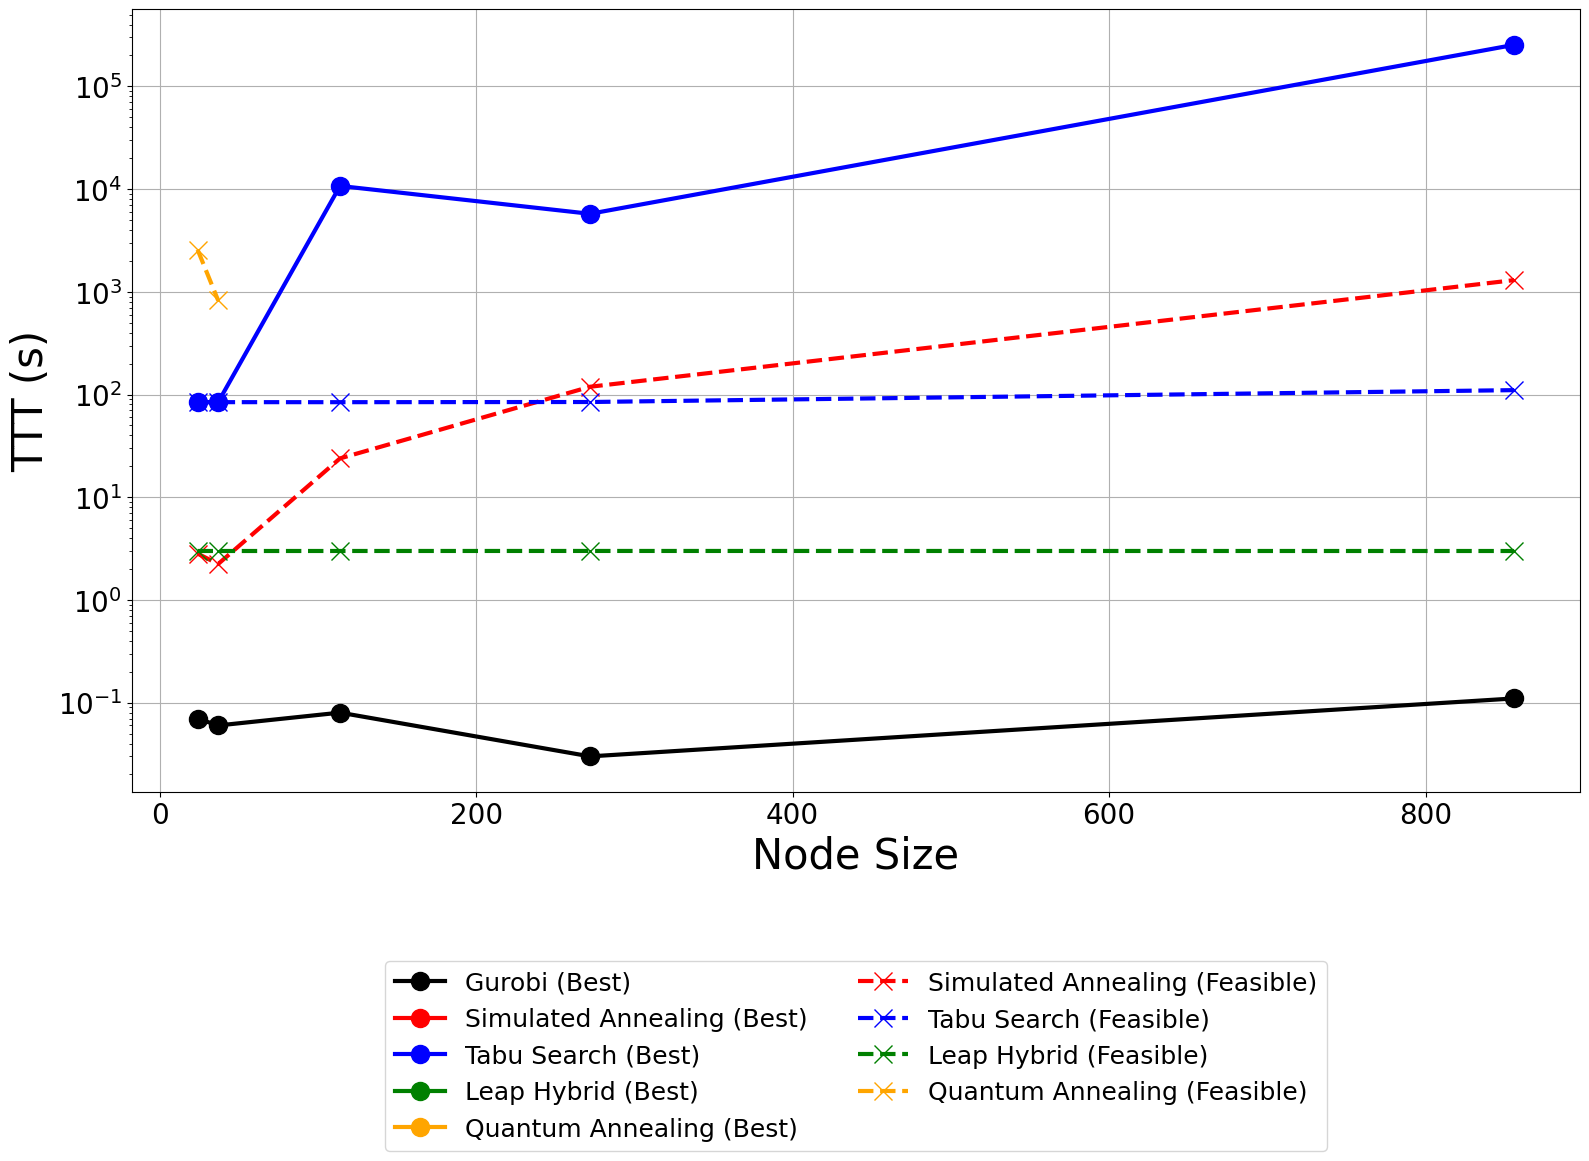

In [792]:
def plot_tts_comparison(nodes, gurobi_best, sim_ann_best, tabu_search_best, leap_hybrid_best, quant_ann_best,
                        gurobi_feasible, sim_ann_feasible, tabu_search_feasible, leap_hybrid_feasible, quant_ann_feasible):
    plt.figure(figsize=(16, 12))

    # Increase line width for better visibility
    line_width = 3
    marker_size = 13  # Adjust marker size

    # Plot for Best Objective Solutions (Optimal)
    plt.plot(nodes, gurobi_best, label='Gurobi (Best)', marker='o', linestyle='-', color='black', linewidth=line_width, markersize=marker_size)
    plt.plot(nodes, sim_ann_best, label='Simulated Annealing (Best)', marker='o', linestyle='-', color='red', linewidth=line_width, markersize=marker_size)
    plt.plot(nodes, tabu_search_best, label='Tabu Search (Best)', marker='o', linestyle='-', color='blue', linewidth=line_width, markersize=marker_size)
    plt.plot(nodes, leap_hybrid_best, label='Leap Hybrid (Best)', marker='o', linestyle='-', color='green', linewidth=line_width, markersize=marker_size)
    plt.plot(nodes, quant_ann_best, label='Quantum Annealing (Best)', marker='o', linestyle='-', color='orange', linewidth=line_width, markersize=marker_size)

    # Plot for Feasible Solutions
    plt.plot(nodes, sim_ann_feasible, label='Simulated Annealing (Feasible)', marker='x', linestyle='--', color='red', linewidth=line_width, markersize=marker_size)
    plt.plot(nodes, tabu_search_feasible, label='Tabu Search (Feasible)', marker='x', linestyle='--', color='blue', linewidth=line_width, markersize=marker_size)
    plt.plot(nodes, leap_hybrid_feasible, label='Leap Hybrid (Feasible)', marker='x', linestyle='--', color='green', linewidth=line_width, markersize=marker_size)
    plt.plot(nodes, quant_ann_feasible, label='Quantum Annealing (Feasible)', marker='x', linestyle='--', color='orange', linewidth=line_width, markersize=marker_size)

    plt.yscale('log')  # Log scale for better visibility of large TTS differences
    plt.xlabel('Node Size', fontsize=30)
    plt.ylabel('TTT (s)', fontsize=30)
    
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)

    # Adjust the legend to have two columns and place it below the plot
    plt.legend(fontsize=18, loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=2)  # Two rows, positioned lower
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Plot TTS for both Best Objective and Feasible Solutions
plot_tts_comparison(
    nodes, 
    gurobi_tts_MIP_best, 
    sim_ann_tts_best, 
    tabu_search_tts_best, 
    leap_hybrid_tts_best, 
    quant_ann_tts_best, 
    gurobi_tts_MIP_feasible, 
    sim_ann_tts_feasible, 
    tabu_search_tts_feasible, 
    leap_hybrid_tts_feasible, 
    quant_ann_tts_feasible
)


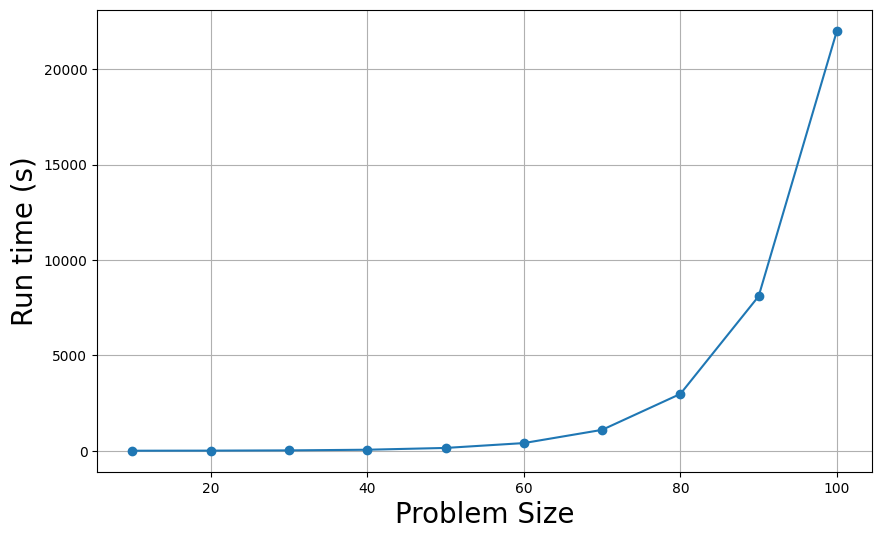

In [794]:
import matplotlib.pyplot as plt
import numpy as np

# Example data
problem_size = np.arange(10, 101, 10)
# exponential growth in time
time_to_solve = np.exp(problem_size / 10)

plt.figure(figsize=(10, 6))
plt.plot(problem_size, time_to_solve, marker='o')
plt.xlabel('Problem Size', fontsize='20')
plt.ylabel('Run time (s)', fontsize='20')
# plt.title('Computational Burden on Solver vs. Problem Size')
plt.grid(True)
plt.show()
